# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

  Running setup.py bdist_wheel for JSAnimation ... done
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation
using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



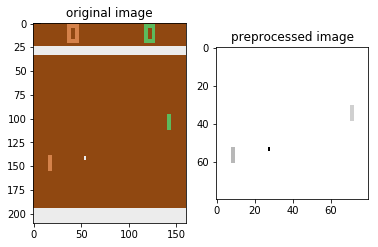

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #Flatten
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))
    


# run your own policy!
policy=Policy().to(device)
#policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


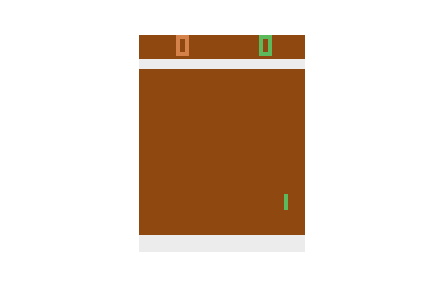
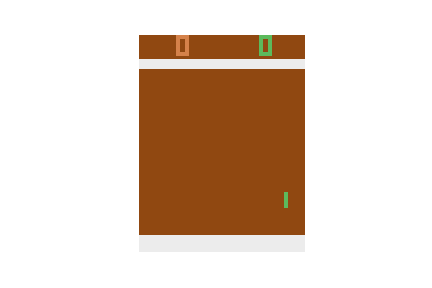
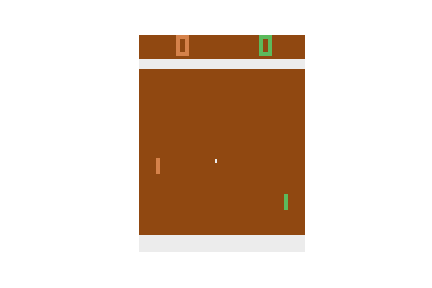
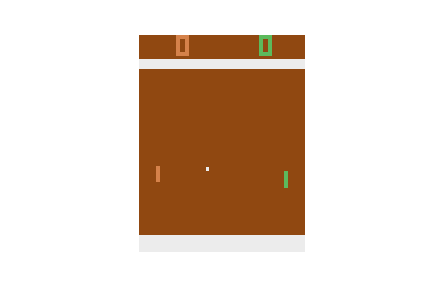
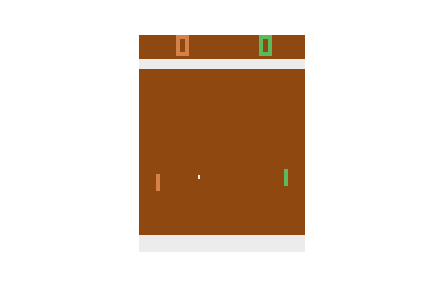
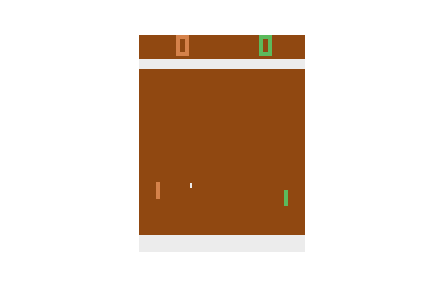
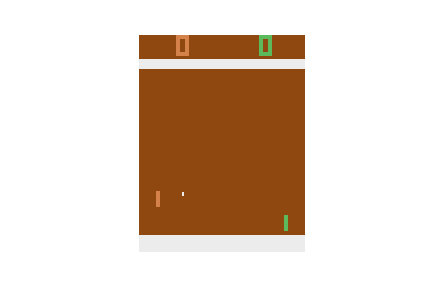
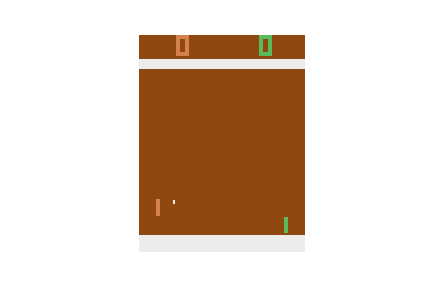
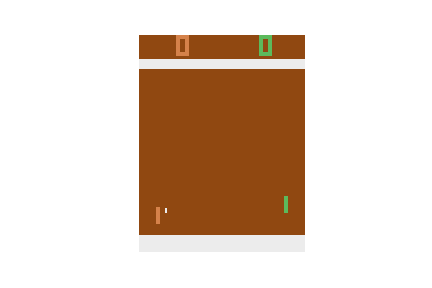
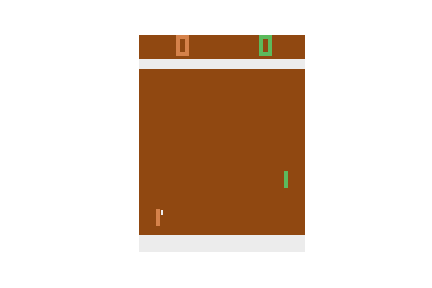
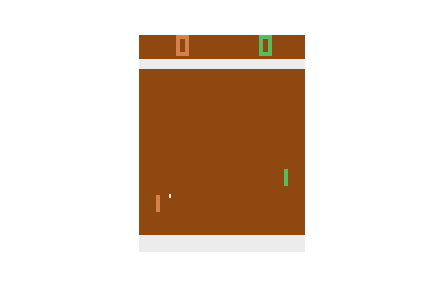
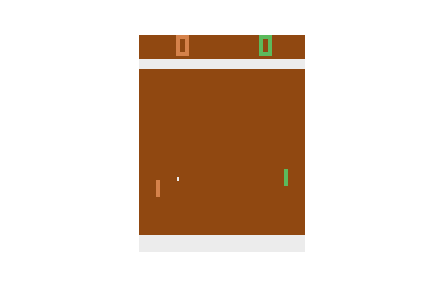
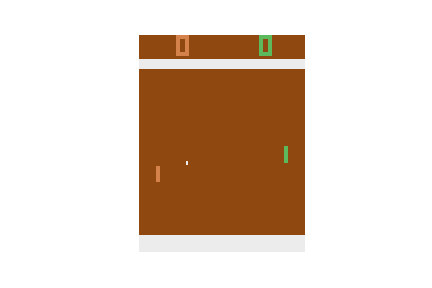
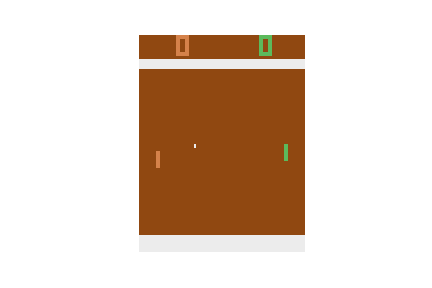
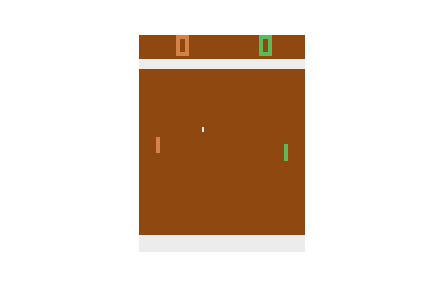
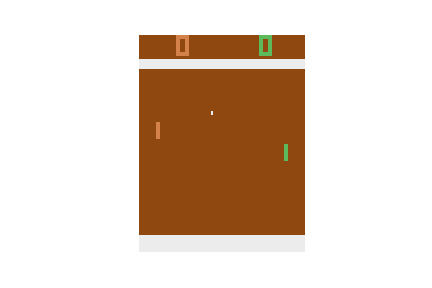
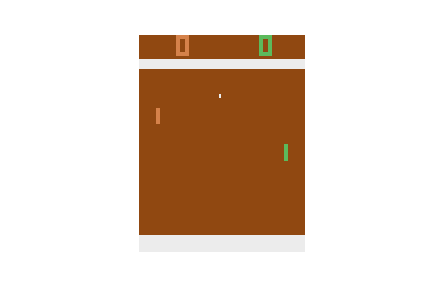
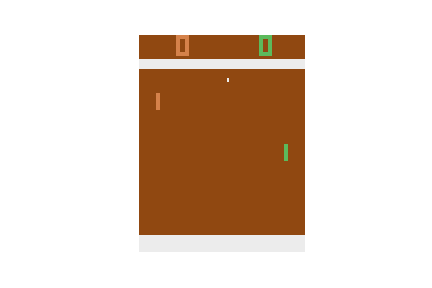
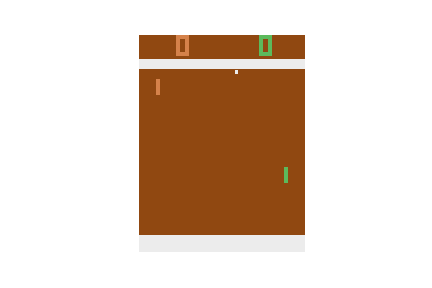
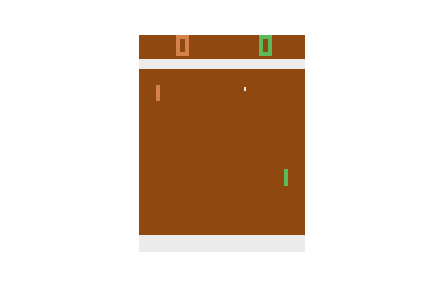
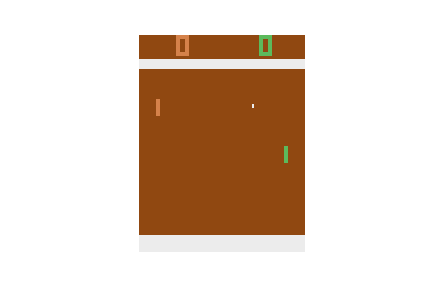
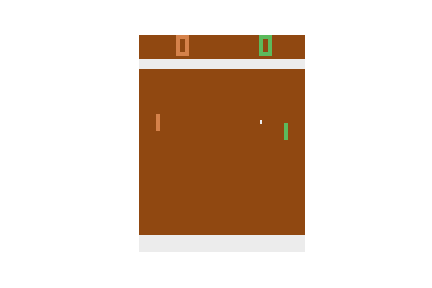
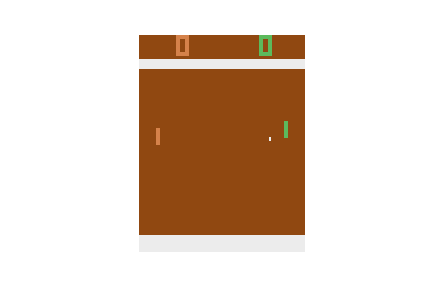
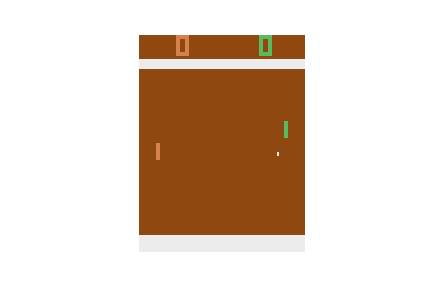
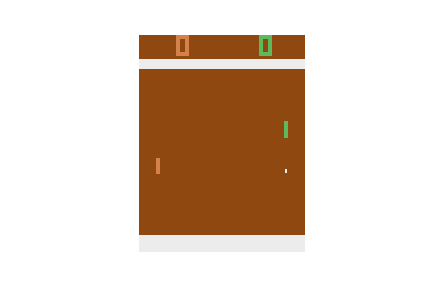
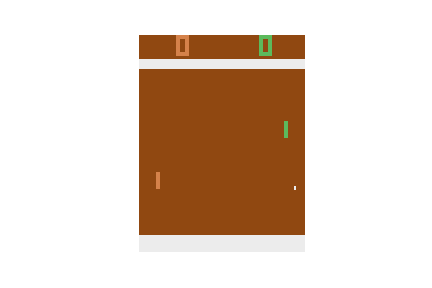
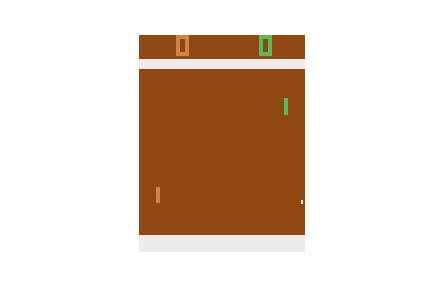
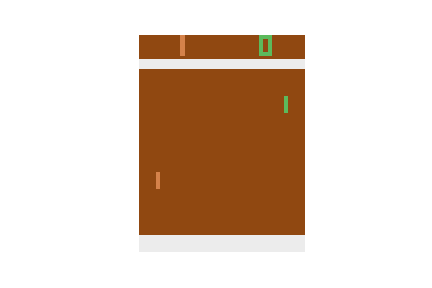
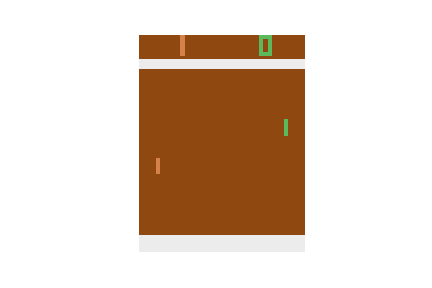
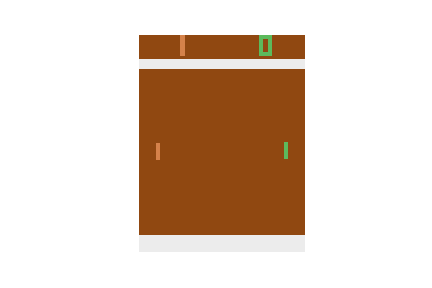
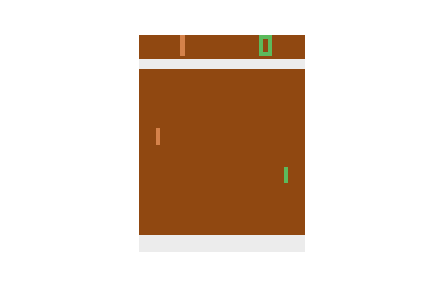
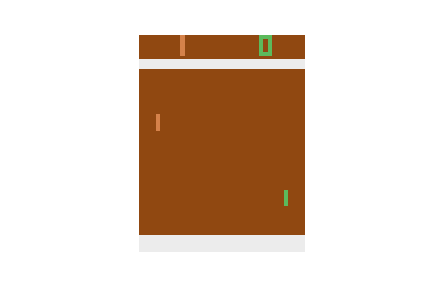
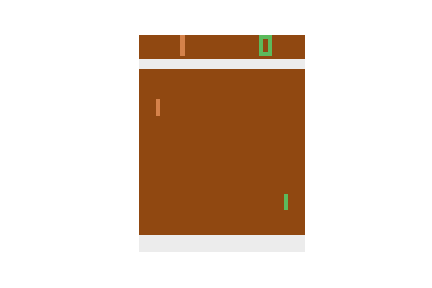
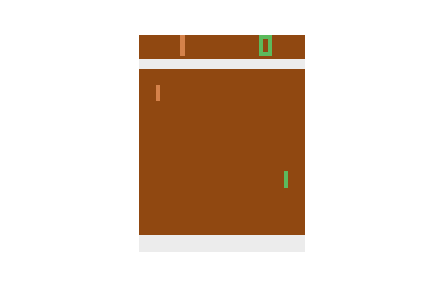
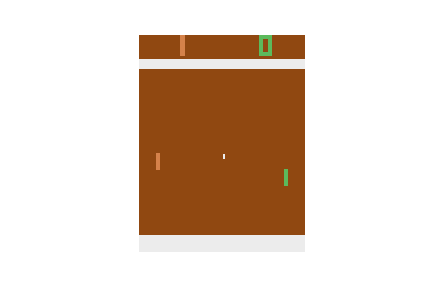
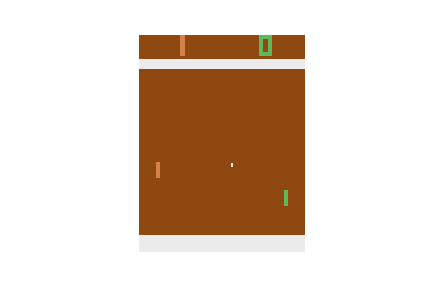
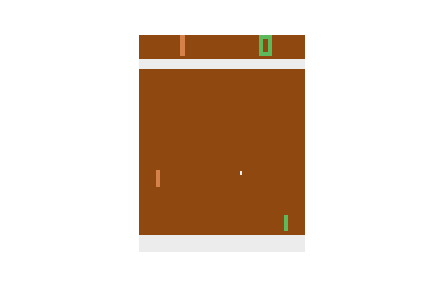
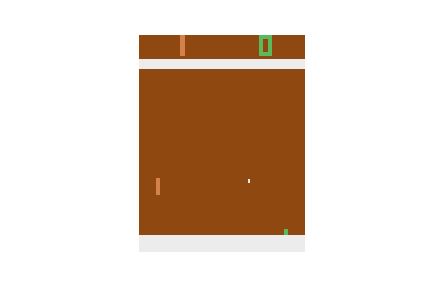
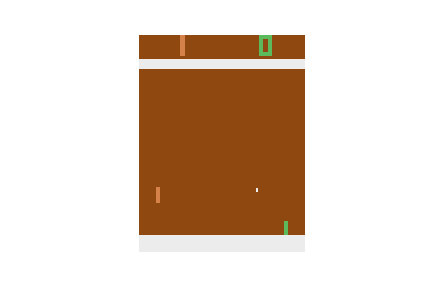
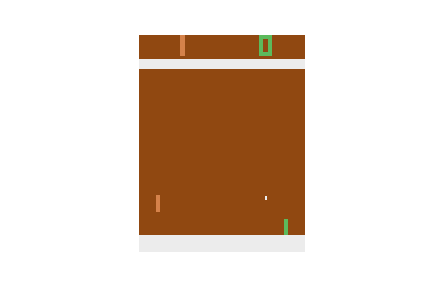
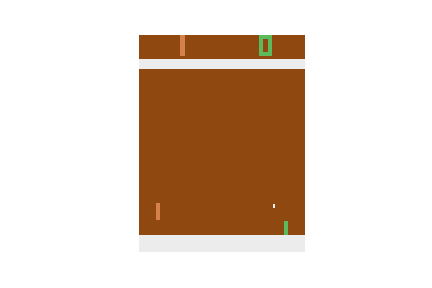
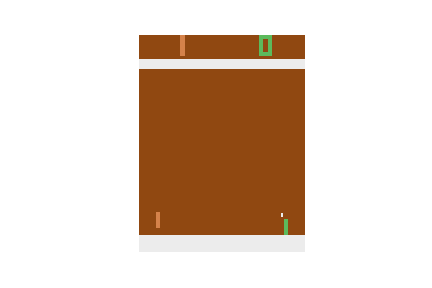
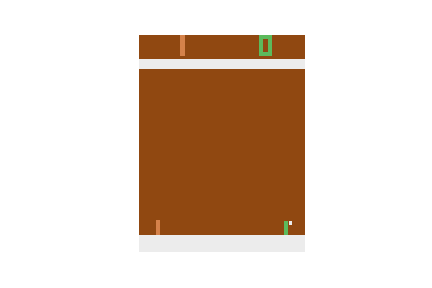
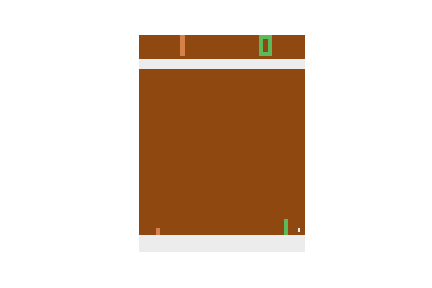
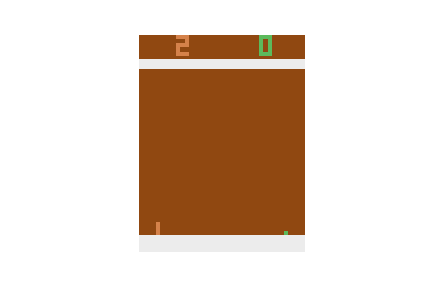
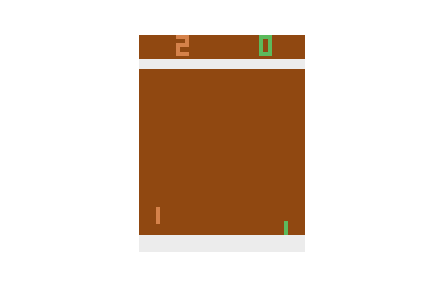
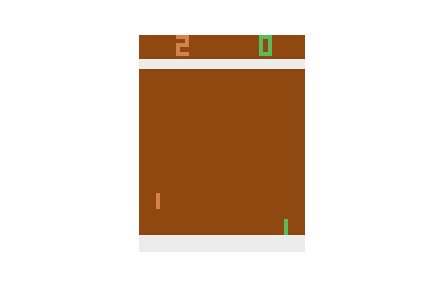
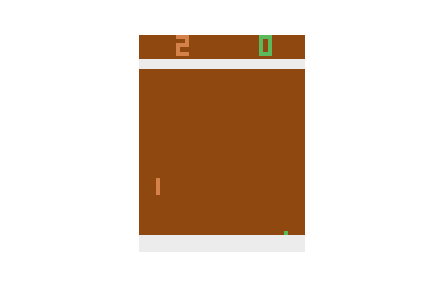
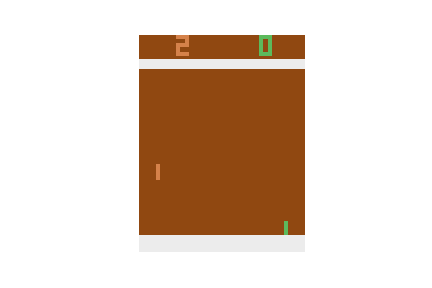
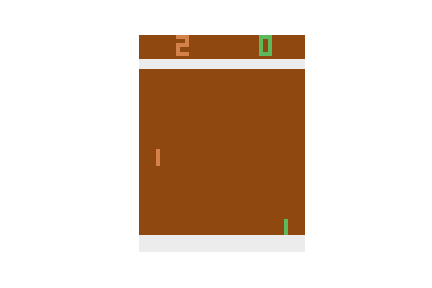
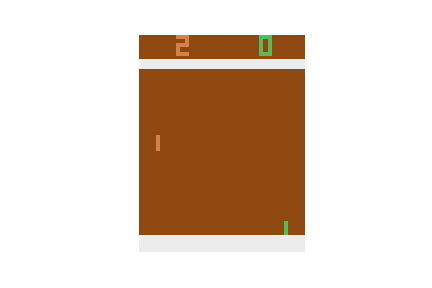
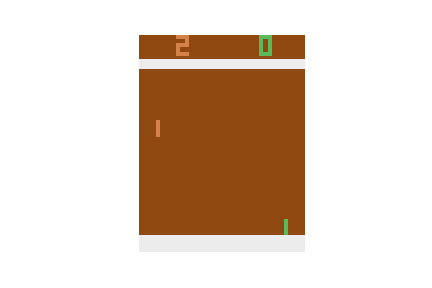
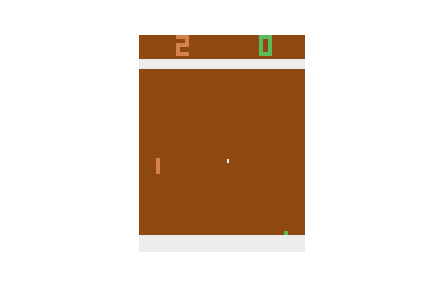
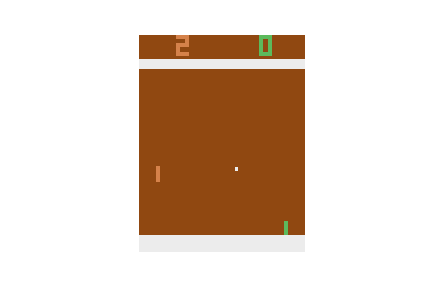
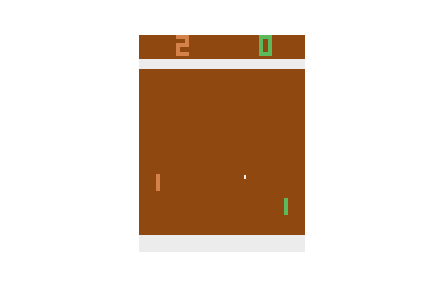
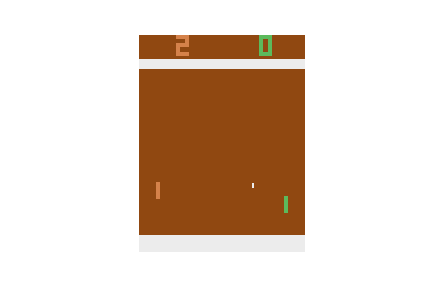
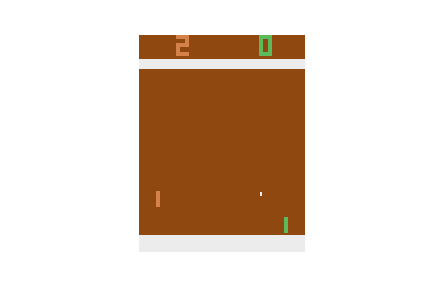
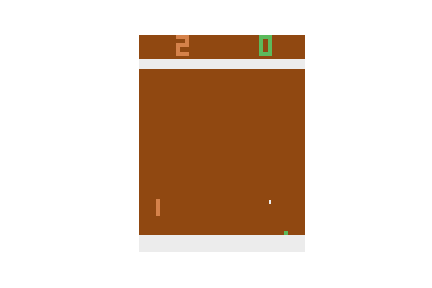
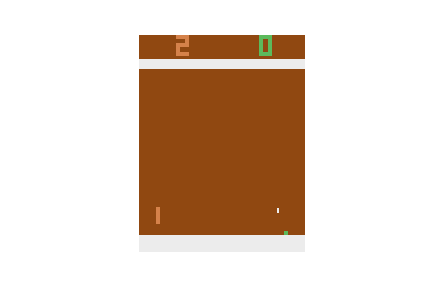
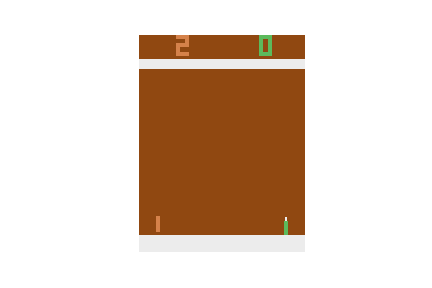
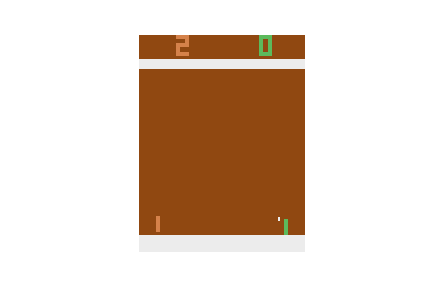
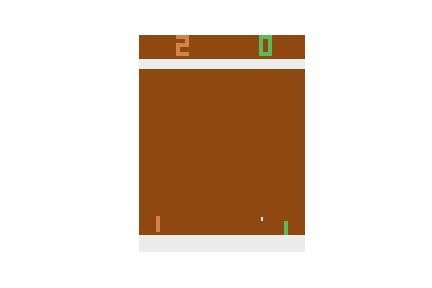
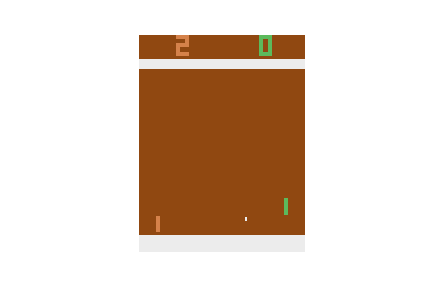
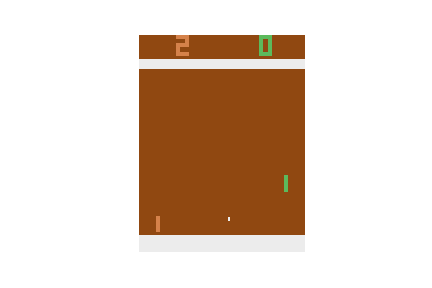
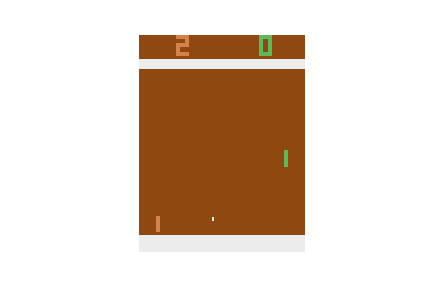
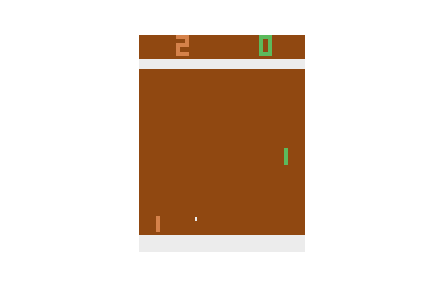
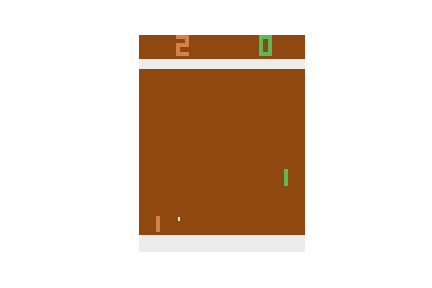
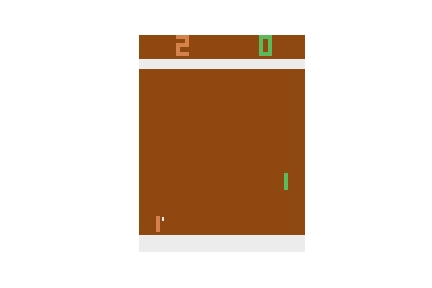
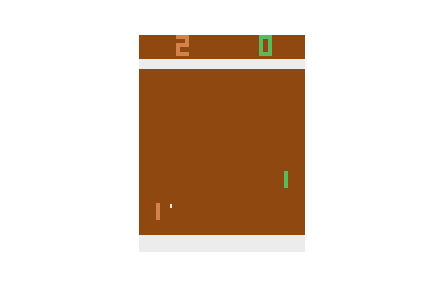
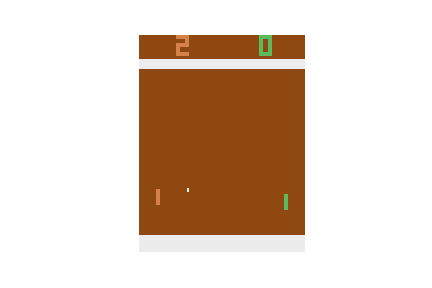
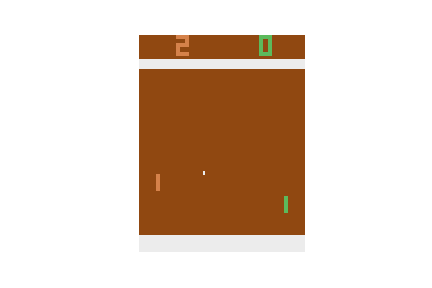
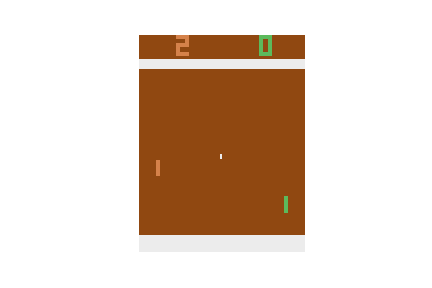
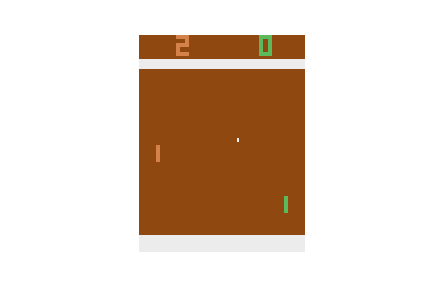
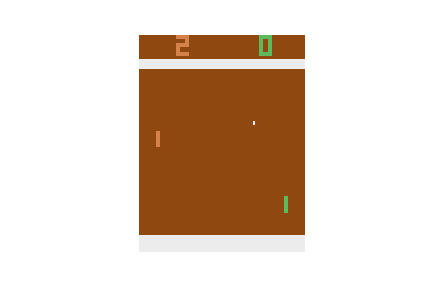
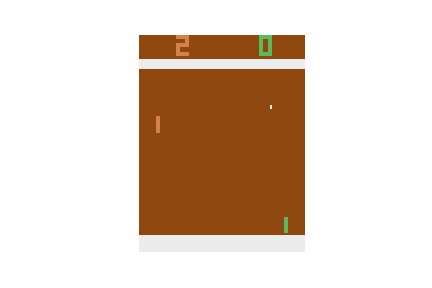
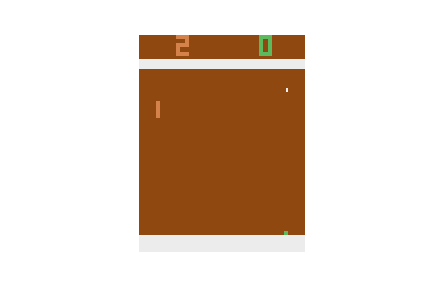
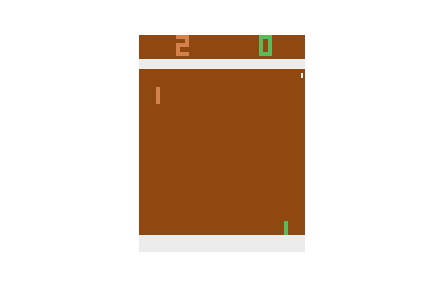
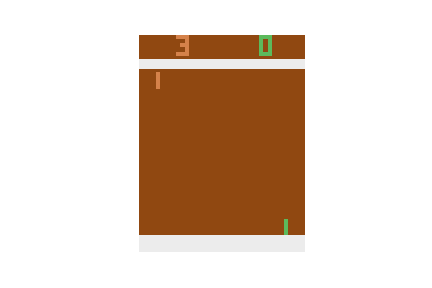
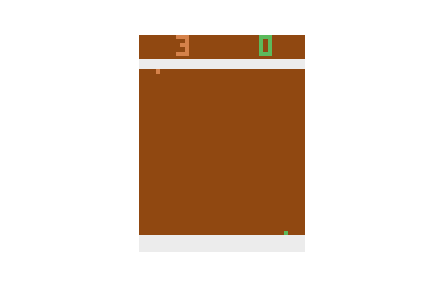
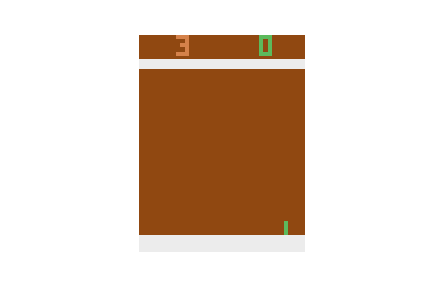
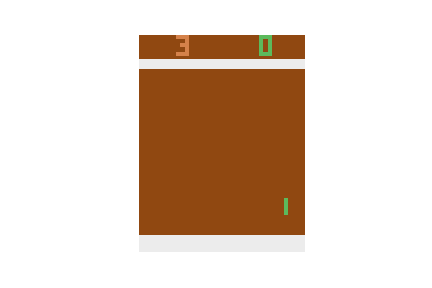
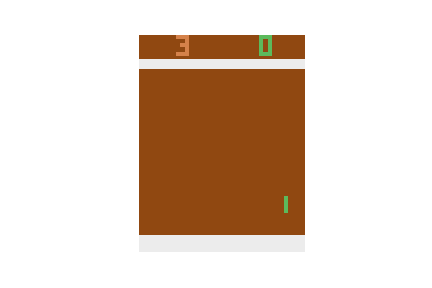
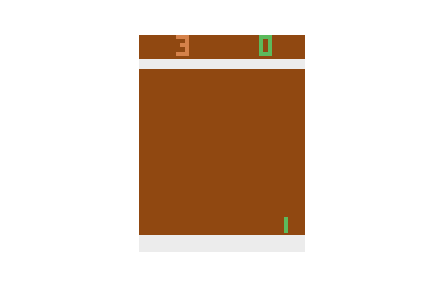
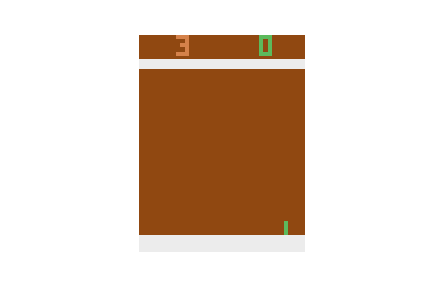
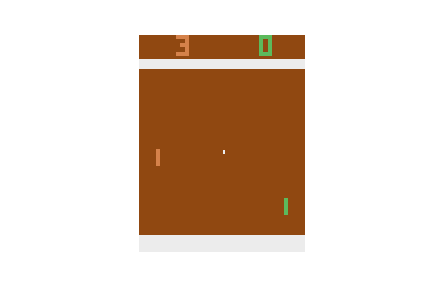
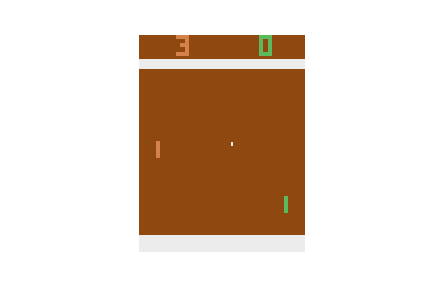
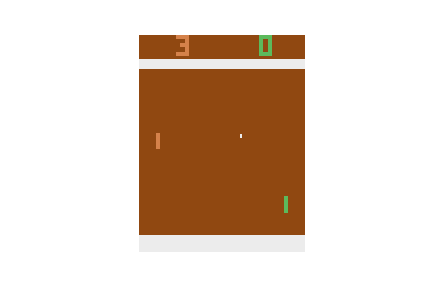
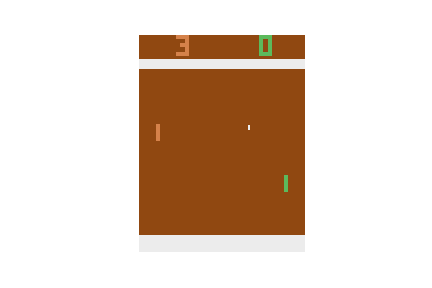
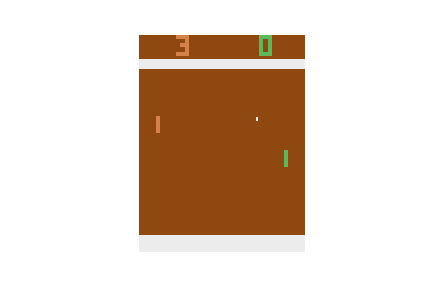
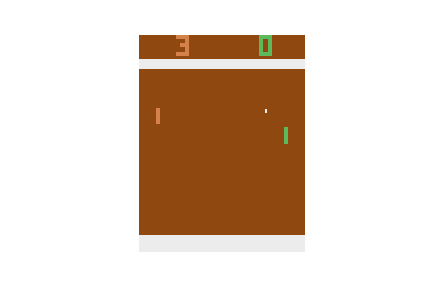
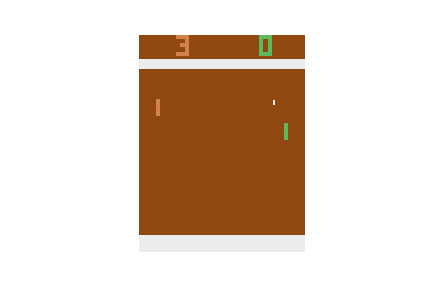
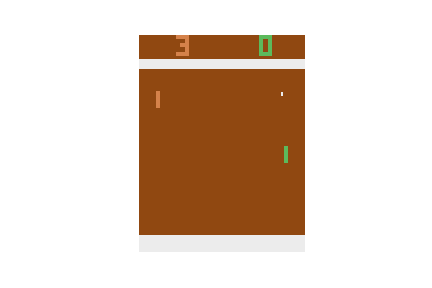
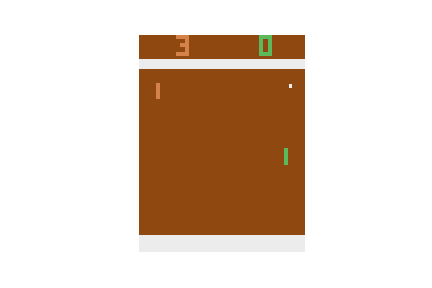
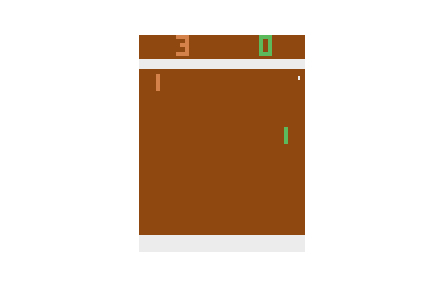
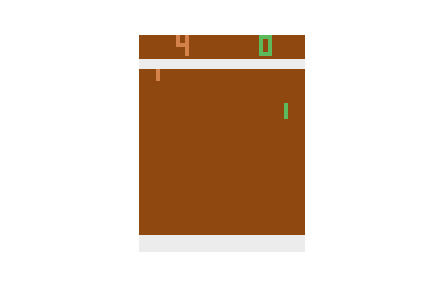
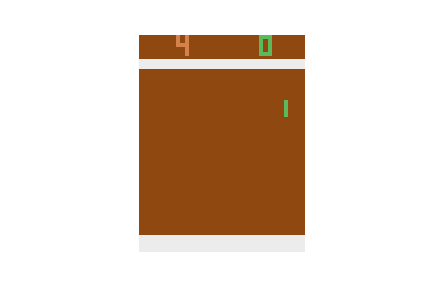
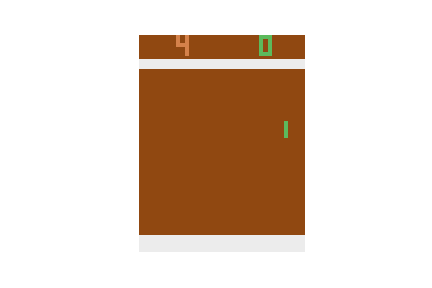
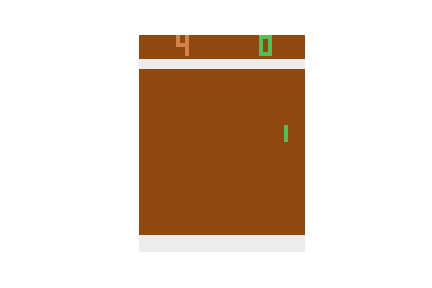
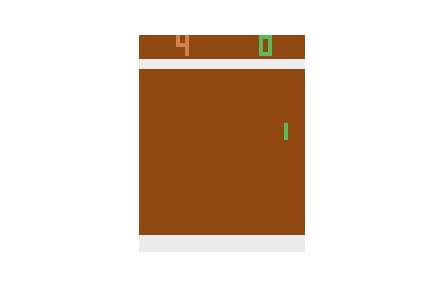
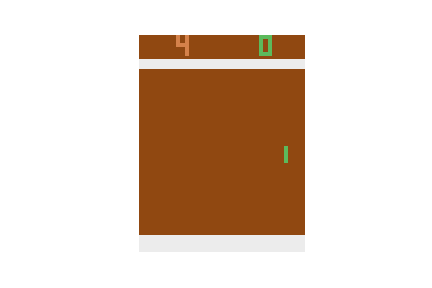
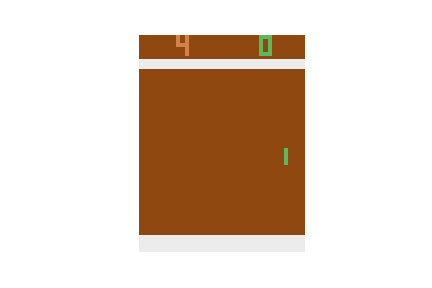
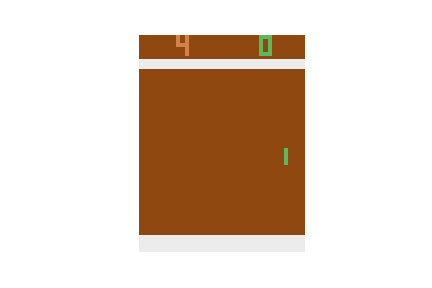
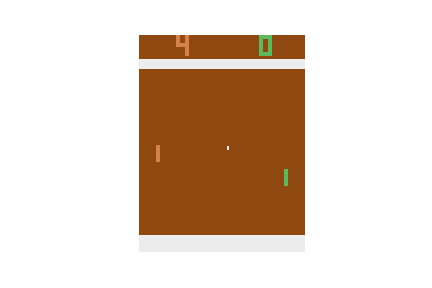
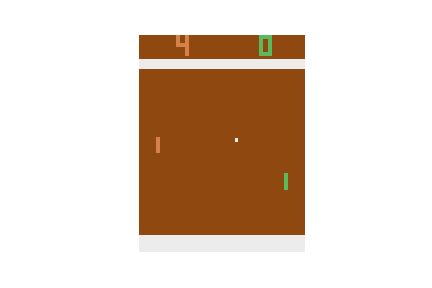
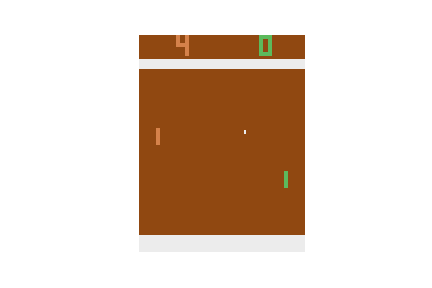
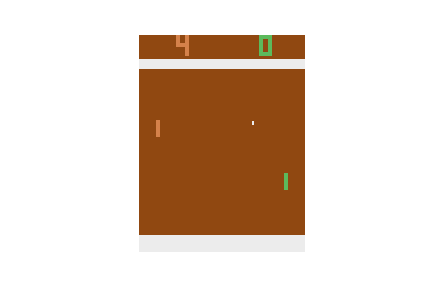
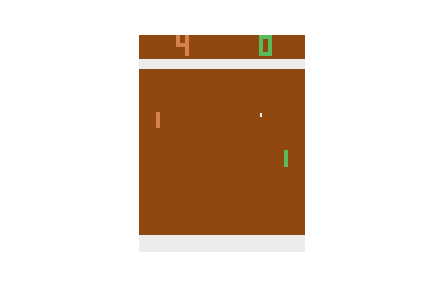
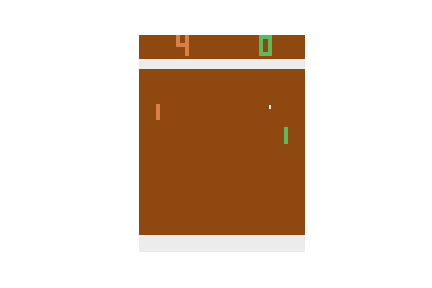
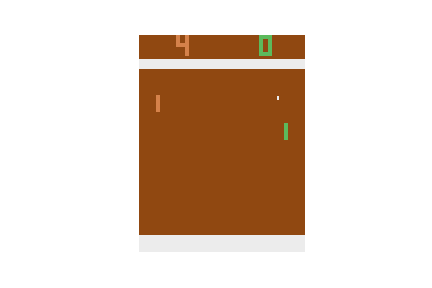
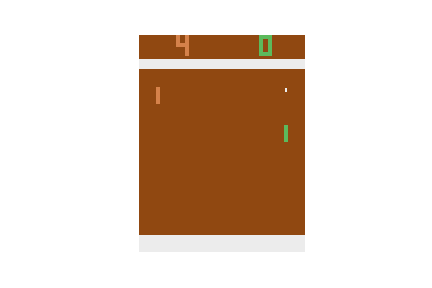
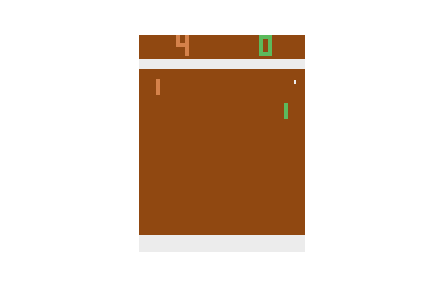
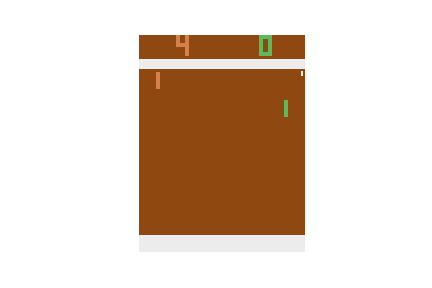
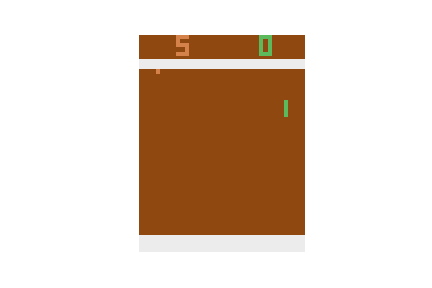
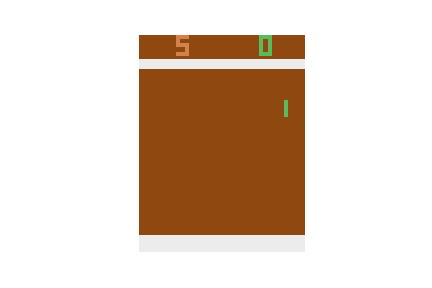
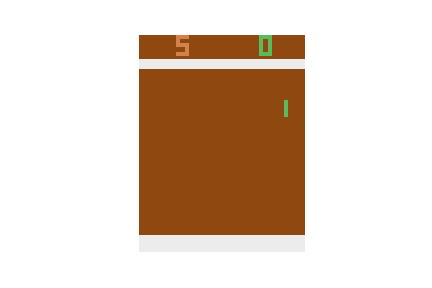
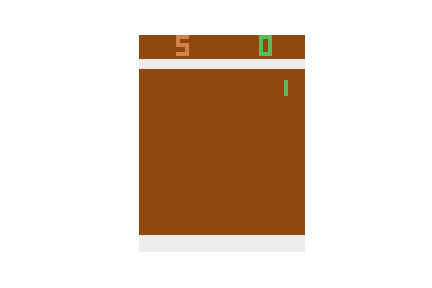
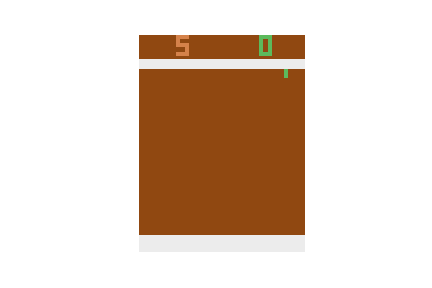
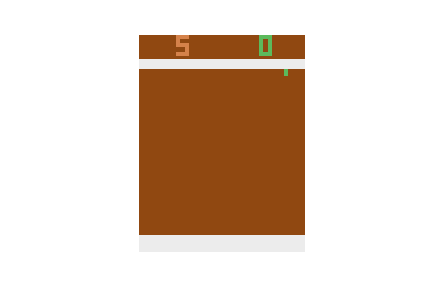
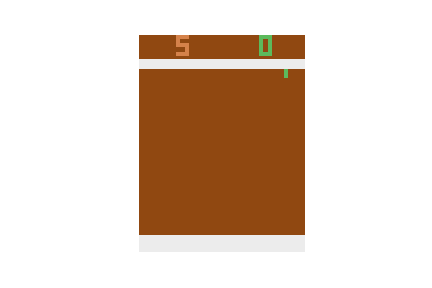
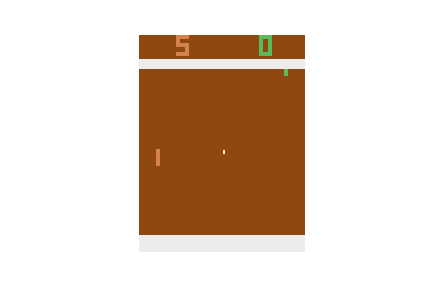
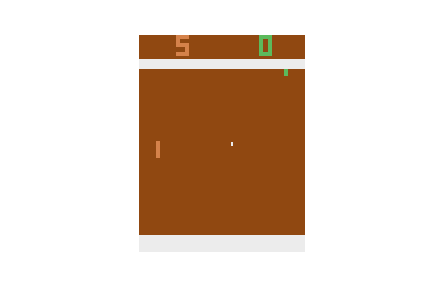
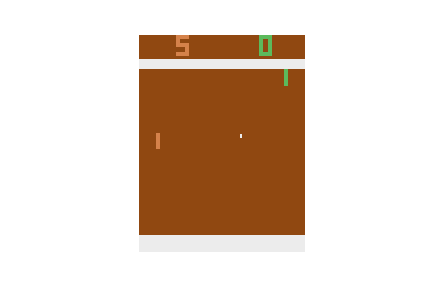
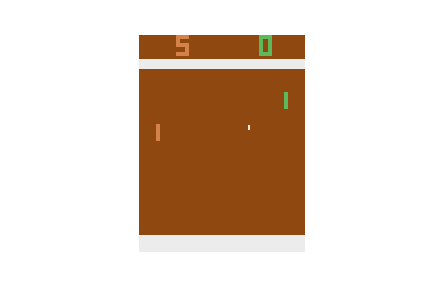
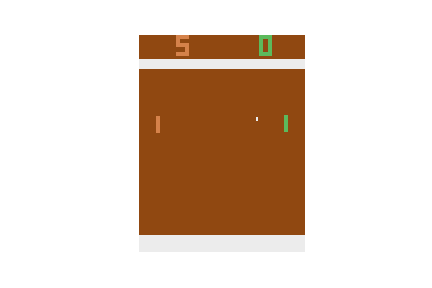
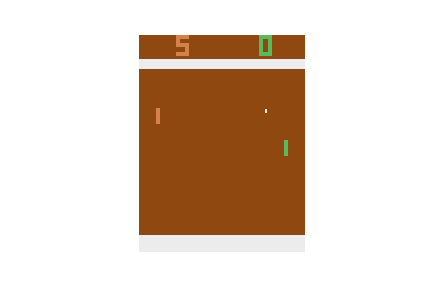
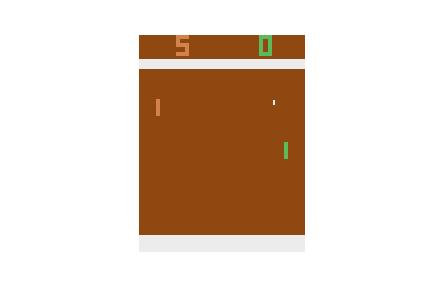
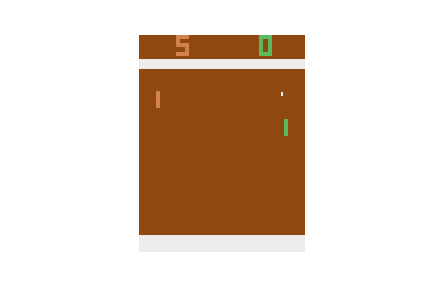
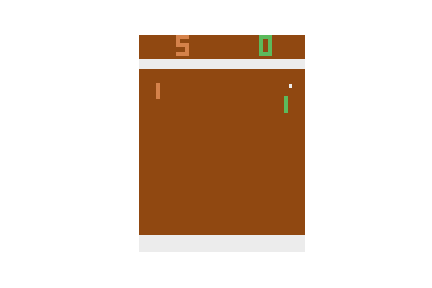
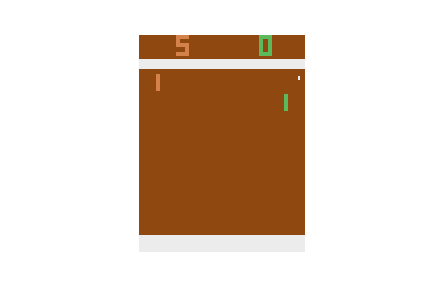
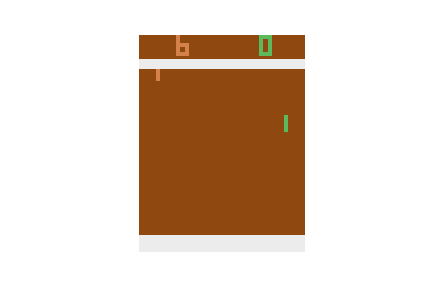
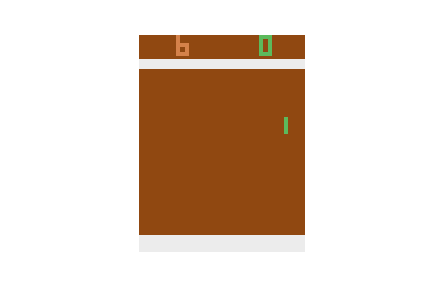
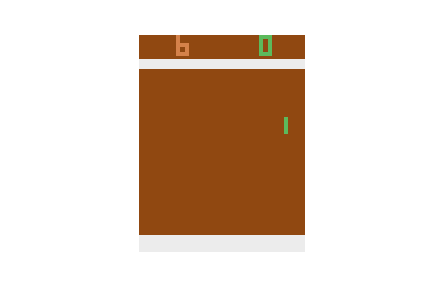
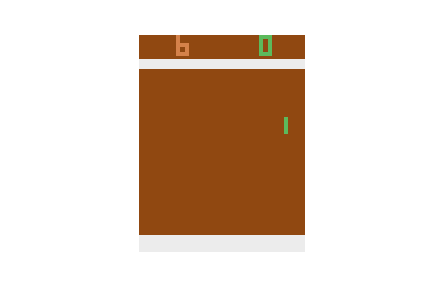
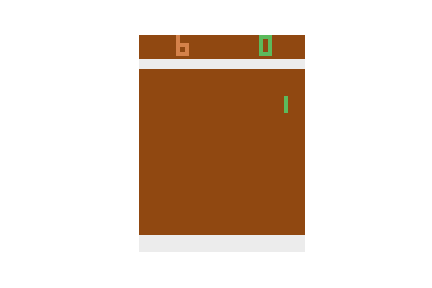
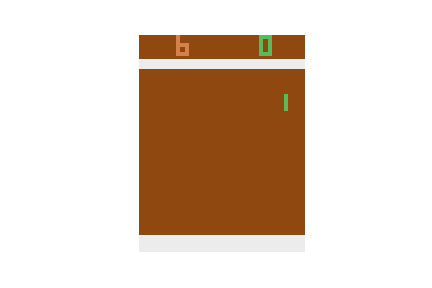
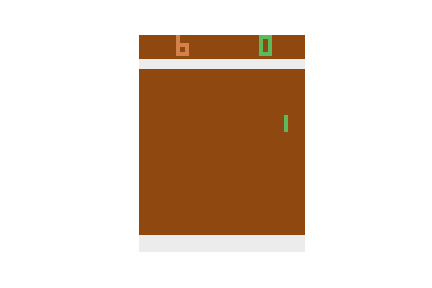
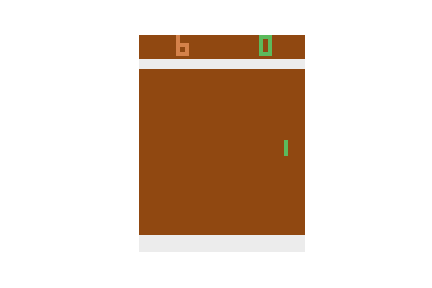
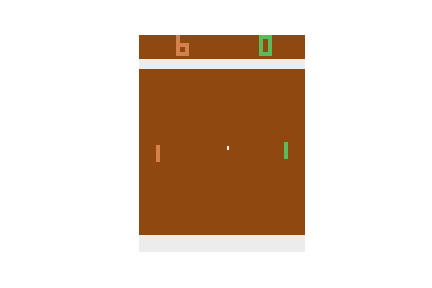
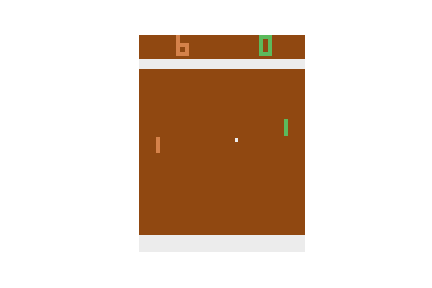
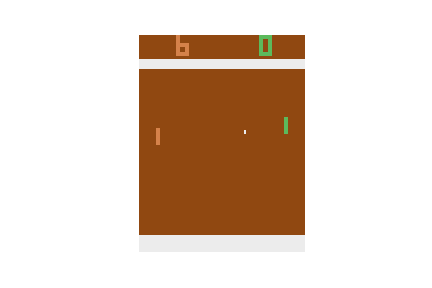
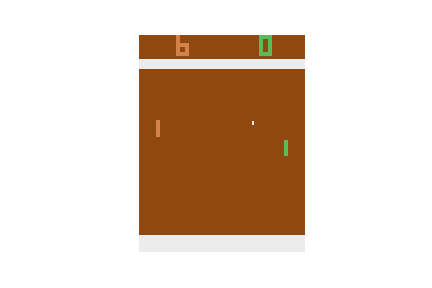
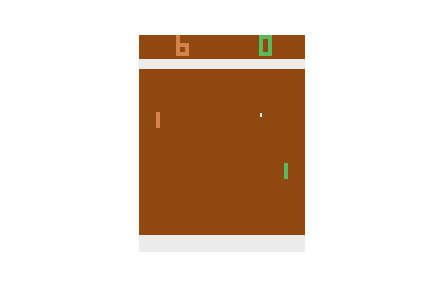
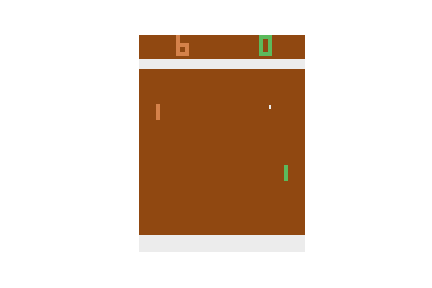
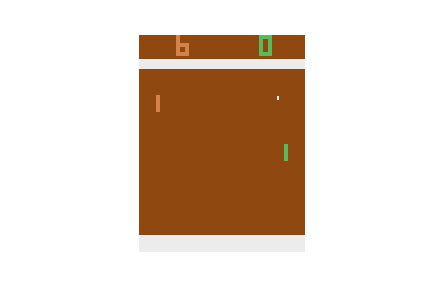
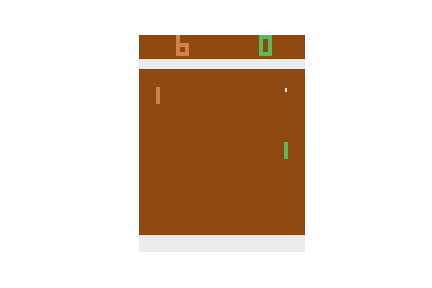
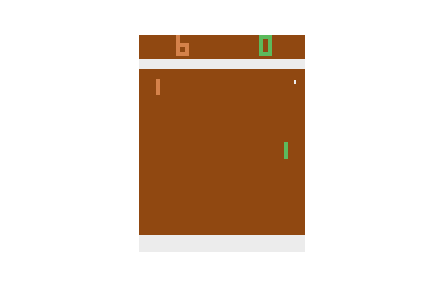
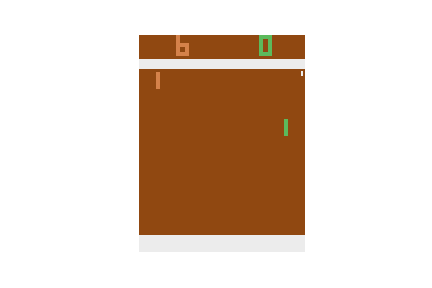
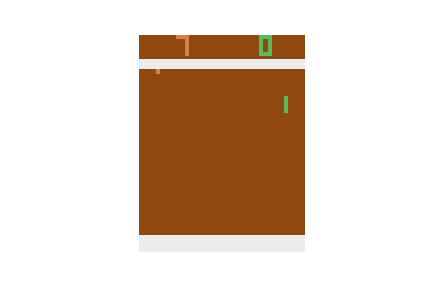
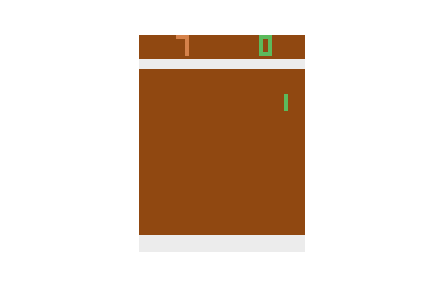
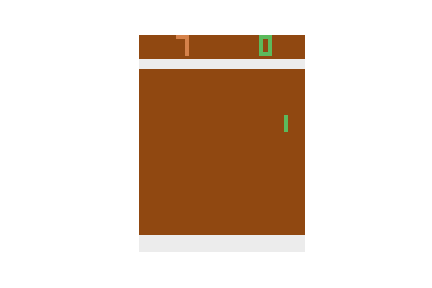
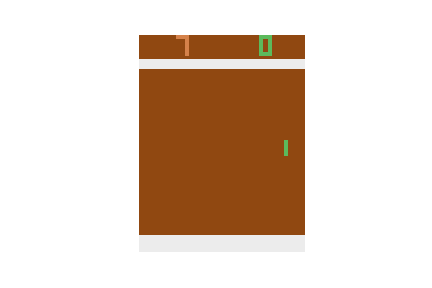
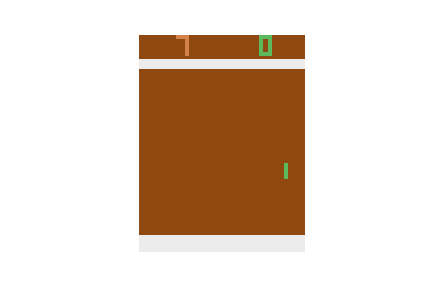
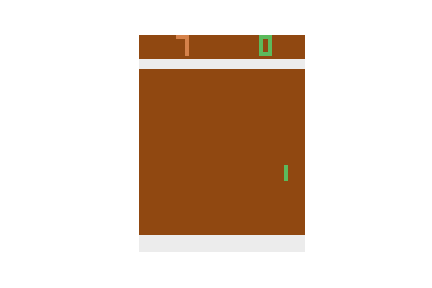
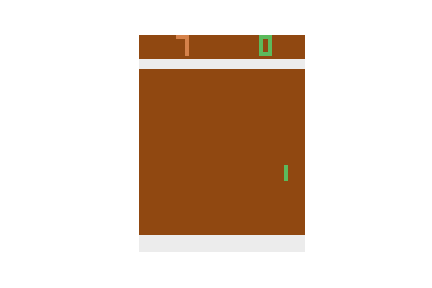
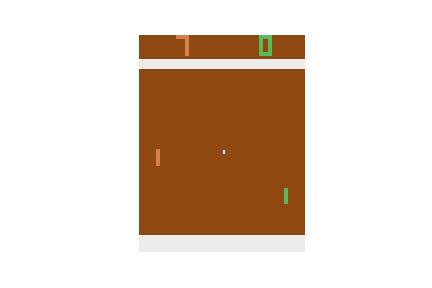
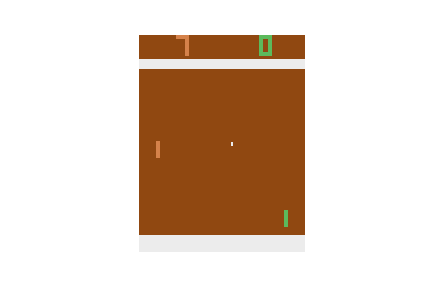
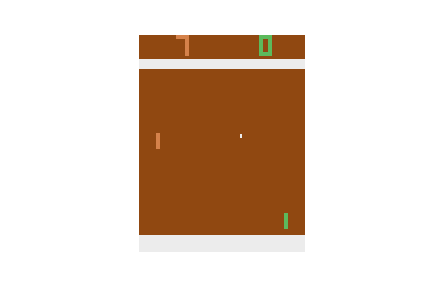
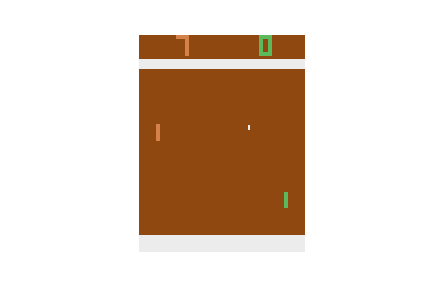
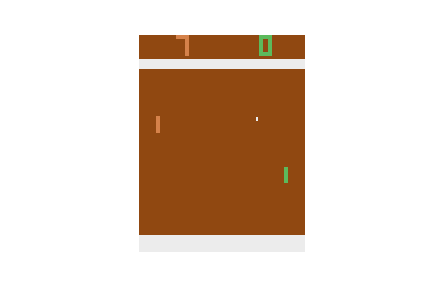
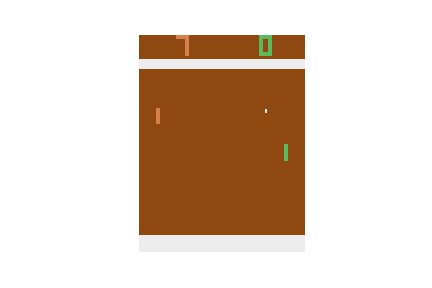
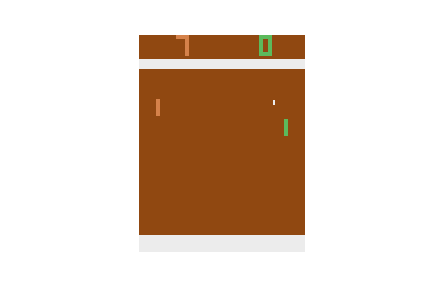
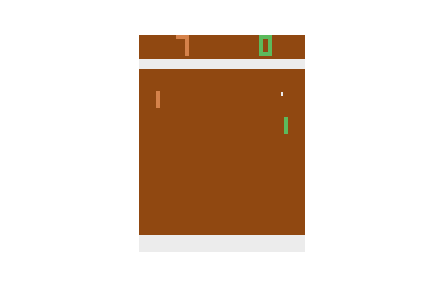
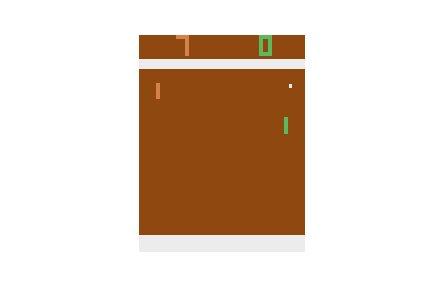
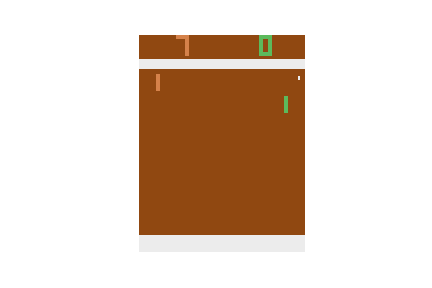
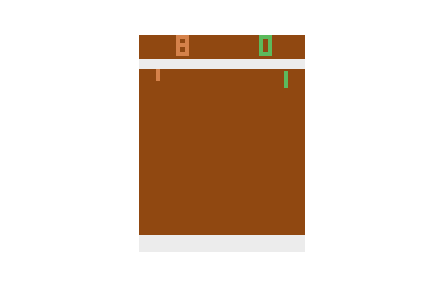
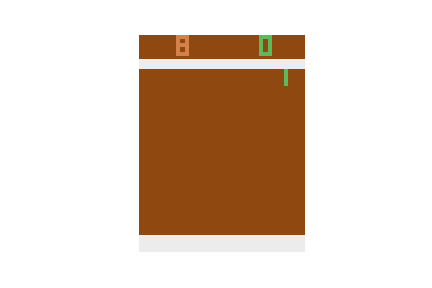
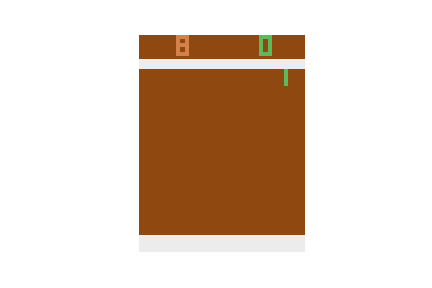
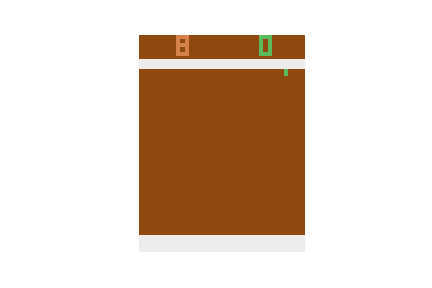
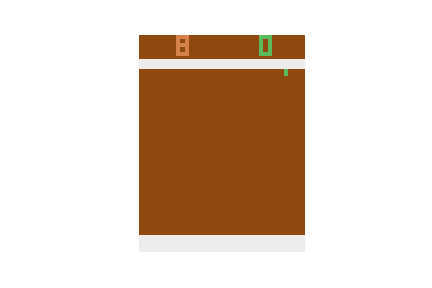
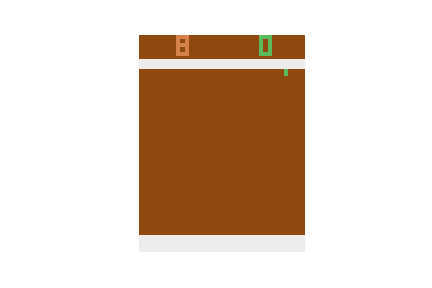
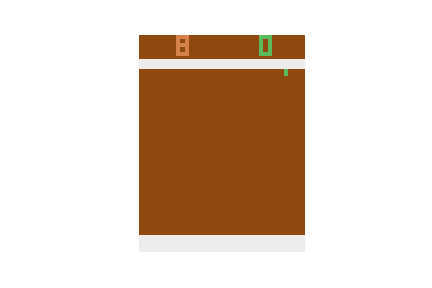
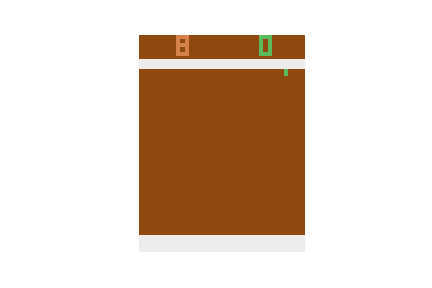
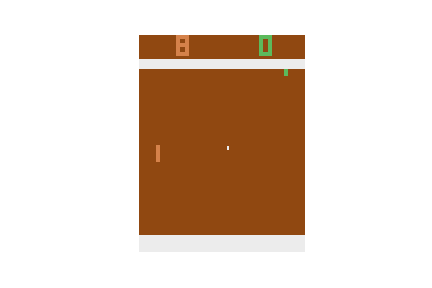
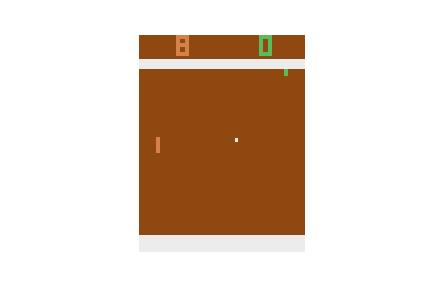
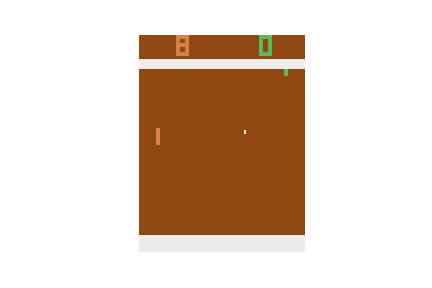
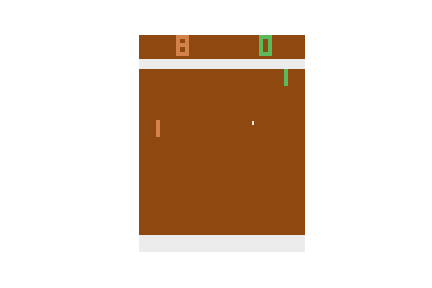
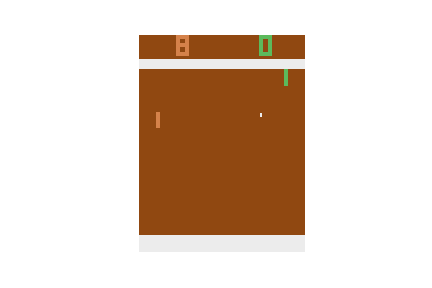
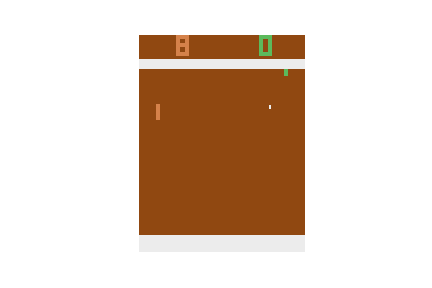
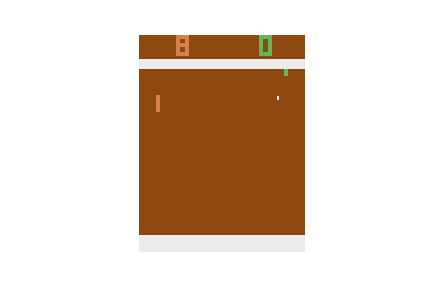
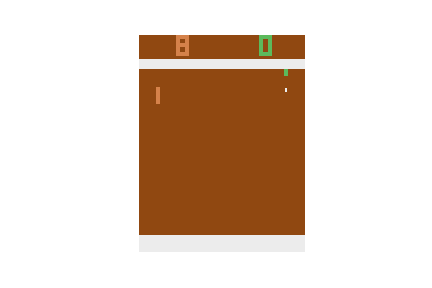
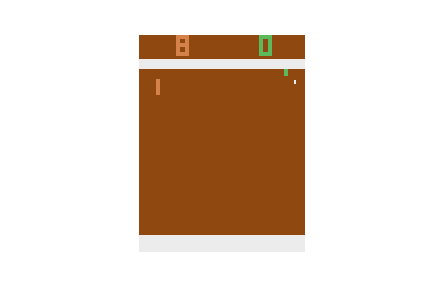
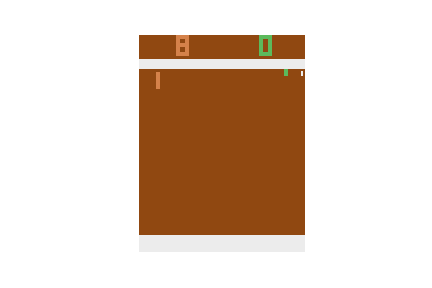
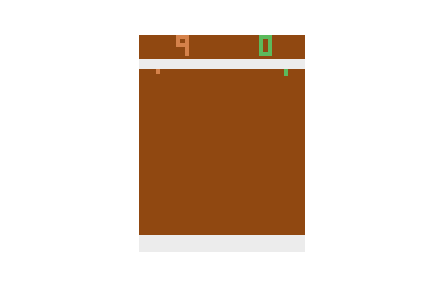
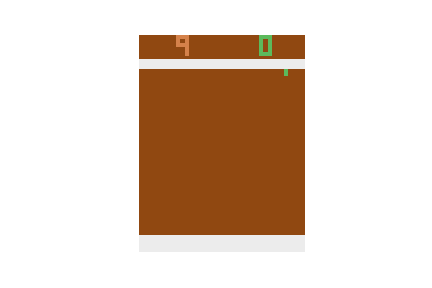
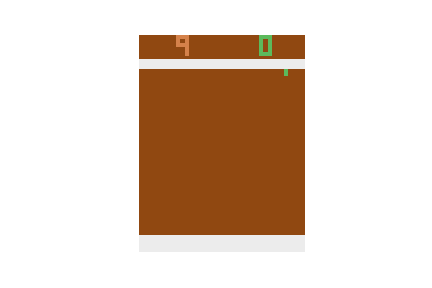
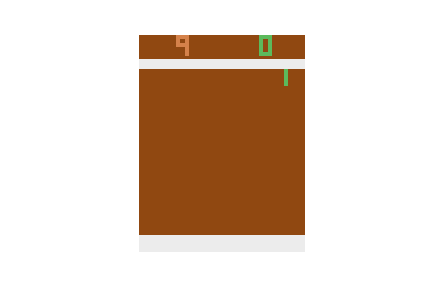
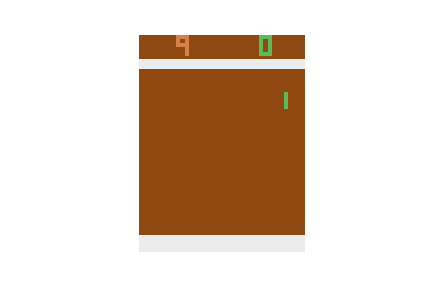
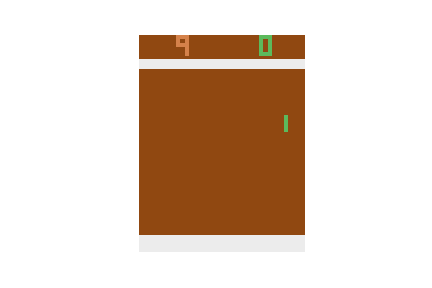
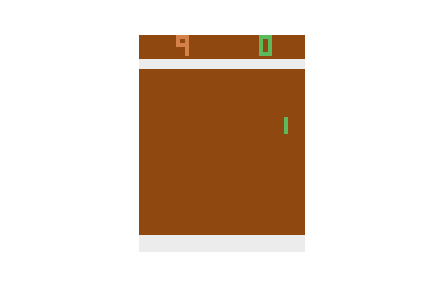
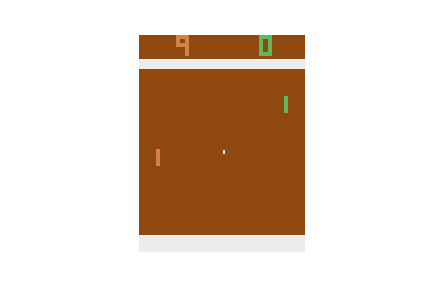
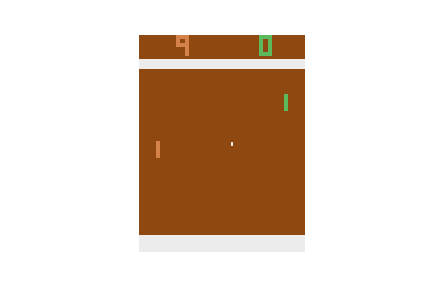
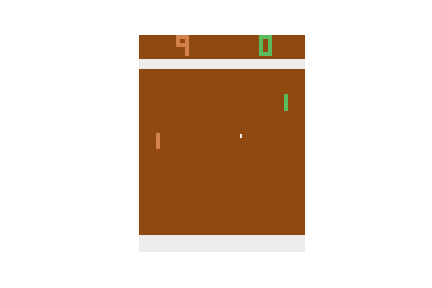
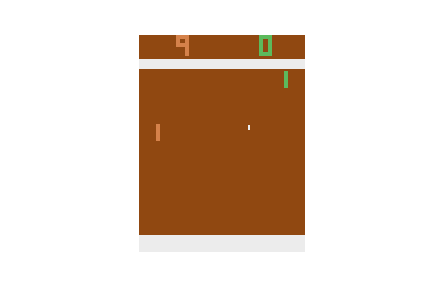
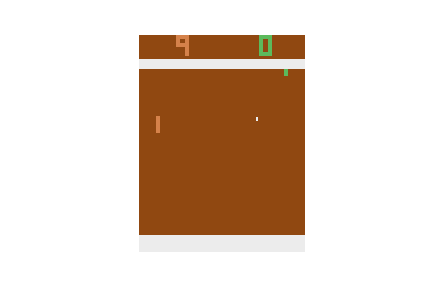
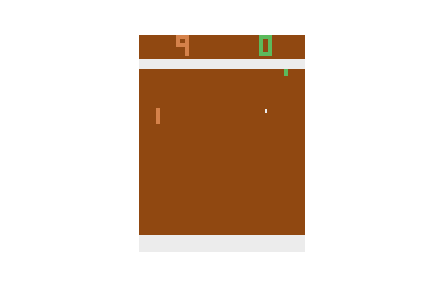
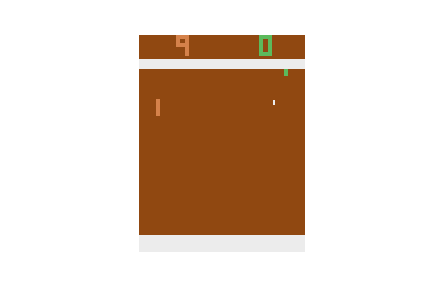
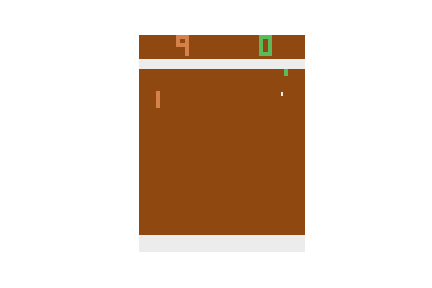
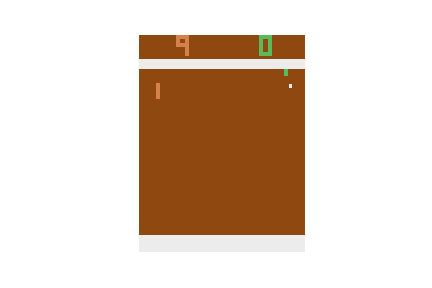
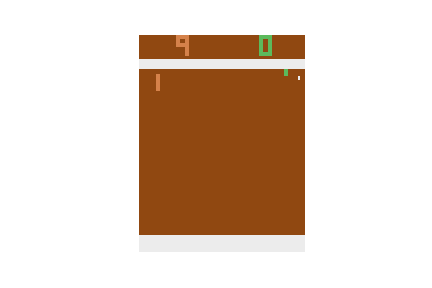
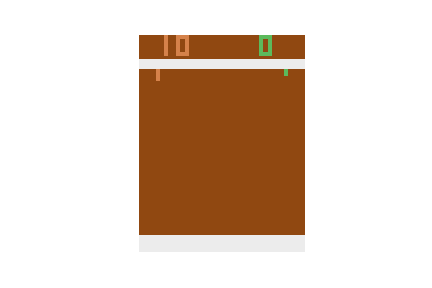

In [5]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [6]:
# Helper
#Pass states through polict network 
#convert states to probability, passing through the policy
def states_to_prob(policy, states):
    states = torch.stack(states)
    policy_input = states.view(-1,*states.shape[-3:])
    return policy(policy_input).view(states.shape[:-3])

RIGHT=4
LEFT=5

In [7]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    
    #Start off by dividing probably
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    """
    cumsum Return the cumulative sum of the elements along a given axis
    t 1 2 3 4 5

    r 0 1 2 3 4
    
    backwards 4 3 2 1 0

    fr 10 9 7 4 0  
    
    """
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    """
    Torch.where(condition, x, y) → Tensor
    turn a tensor of elements selected from either x or y, depending on condition.
    """
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
    
    #This is the key step
    ratio = new_probs/old_probs
    """
    Intuitively, it adds more cost to actions that too quickly dominate, 
    and the higher cost favors more exploration 
    (on top of the random e-greediness).
    
    .For on-policy models, the same mutual reinforcement behavior 
    will also lead to highly-peaked π(a|s) towards a few actions 
    (or a few fixed action sequences), 
    since it is always easy for both actor and critic to over-optimize
    on a small portion of the environment, 
    and end up “living in their own realities”. To reduce the problem, 
    [Mnih et al. (2016)] 
    added an entropy term to the loss to encourage diversity,
    which we find to be critical.
    """
    #Prevents 0 and 1 from being reached, encouraging exploration
    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    
    #Clamping introduced here
    #Torch clamp Clamp all elements in input into the range [min, max] and return a resulting Tensor.
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    #Take the minimum of original surrogate vs clipped surrogate
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)
    
    
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    
    #Introduce the 1/T implicitly by taking the mean
    #We need to introduce a clipping function in this, to make sure if some value is too high?
    return torch.mean(ratio*rewards + beta*entropy)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [8]:
from parallelEnv import parallelEnv
from workspace_utils import active_session
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 1000

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []
with active_session():
    
    for e in range(episode):

        # collect trajectories and hold on to them with old probs
        old_probs, states, actions, rewards = \
            pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
        total_rewards = np.sum(rewards, axis=0)

        #create new probs while holding on to the same old probs
        # gradient ascent step
        for _ in range(SGD_epoch):
        
            # uncomment to utilize your own clipped function! Gradient ascent so we implement negative loss
            L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        
            optimizer.zero_grad()
            L.backward()
            optimizer.step()
            del L
    
        # the clipping parameter reduces as time goes on
        epsilon*=.999
    
        # the regulation term also reduces
        # this reduces exploration in later runs
        beta*=.995
    
        # get the average reward of the parallel environments
        mean_rewards.append(np.mean(total_rewards))
    
        # display some progress every 20 iterations
        if (e+1)%20 ==0 :
            print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
            print(total_rewards)
        
        # update progress widget bar
        timer.update(e+1)
    
    timer.finish()

  Running setup.py bdist_wheel for progressbar ... done
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built progressbar


Episode: 20, score: -16.000000
[-16. -16. -16. -16. -16. -16. -15. -17.]


Episode: 40, score: -13.625000
[-10. -12. -17. -14. -11. -16. -16. -13.]


Episode: 60, score: -12.375000
[-14. -12. -10. -16. -14. -13. -10. -10.]


Episode: 80, score: -12.375000
[-11.  -9. -16. -11. -16. -11. -10. -15.]


Episode: 100, score: -13.750000
[ -7. -15. -15. -14. -16. -13. -16. -14.]


Episode: 120, score: -12.750000
[-15. -11. -12. -11. -14. -13. -13. -13.]


Episode: 140, score: -11.625000
[ -9. -11. -10. -13. -14. -14. -10. -12.]


Episode: 160, score: -12.000000
[-15. -11. -13. -12. -12. -13.  -6. -14.]


Episode: 180, score: -8.750000
[ -9.  -9.  -6. -10. -10.  -6. -11.  -9.]


Episode: 200, score: -9.875000
[-13. -12. -11. -10. -10. -10.  -4.  -9.]


Episode: 220, score: -5.500000
[-7. -6. -7. -4. -4. -6. -8. -2.]


Episode: 240, score: -3.000000
[-1. -4.  0. -4. -5. -6. -3. -1.]


Episode: 260, score: -2.375000
[-5. -1. -2. -2. -1.  0. -4. -4.]


Episode: 280, score: -1.125000
[-4.  0.  0.  1.  2. -4. -3. -1.]


Episode: 300, score: 1.625000
[ 3.  2.  3.  4.  0.  1.  0.  0.]


Episode: 320, score: 2.000000
[ 3.  3. -1. -1.  3.  1.  4.  4.]


Episode: 340, score: 2.125000
[ 1. -1.  3.  5.  3.  2.  3.  1.]


Episode: 360, score: 3.250000
[ 3.  3.  5.  5.  3.  1.  3.  3.]


Episode: 380, score: 4.250000
[ 5.  3.  1.  5.  5.  5.  5.  5.]


Episode: 400, score: 3.500000
[ 5.  3.  1.  3.  5.  3.  5.  3.]


Episode: 420, score: 3.875000
[ 5.  5.  0.  3.  5.  5.  5.  3.]


Episode: 440, score: 4.625000
[ 5.  5.  5.  5.  4.  5.  3.  5.]


Episode: 460, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 480, score: 4.500000
[ 5.  1.  5.  5.  5.  5.  5.  5.]


Episode: 500, score: 4.500000
[ 5.  5.  5.  5.  1.  5.  5.  5.]


Episode: 520, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 540, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 560, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 580, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 600, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 620, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 640, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 660, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 680, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 700, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 720, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 740, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 760, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 780, score: 4.750000
[ 5.  5.  5.  5.  5.  5.  3.  5.]


Episode: 800, score: 4.750000
[ 5.  5.  5.  5.  5.  5.  5.  3.]


Episode: 820, score: 4.750000
[ 5.  5.  5.  3.  5.  5.  5.  5.]


Episode: 840, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 860, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 880, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 900, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 920, score: 3.375000
[ 5.  5. -2.  5.  1.  3.  5.  5.]


Episode: 940, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 960, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 980, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]


Episode: 1000, score: 5.000000
[ 5.  5.  5.  5.  5.  5.  5.  5.]



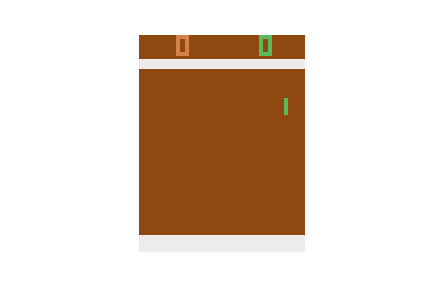
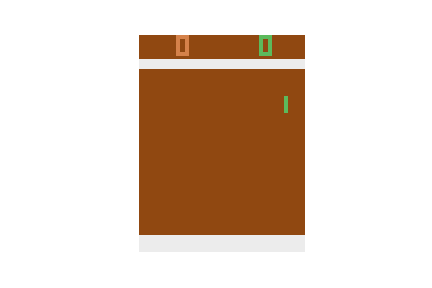
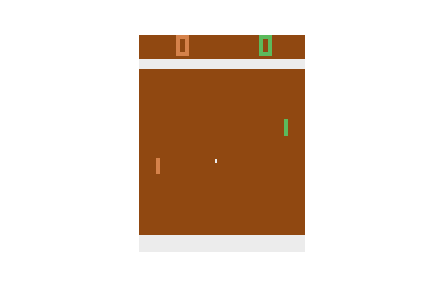
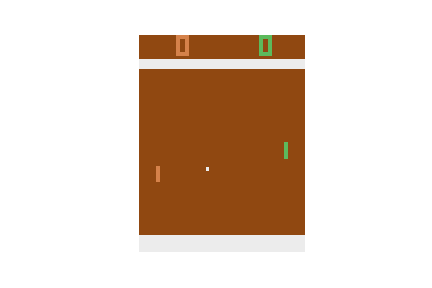
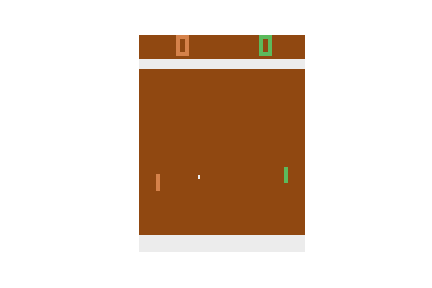
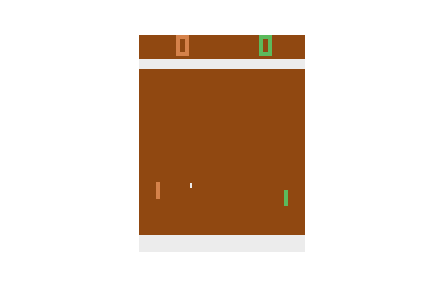
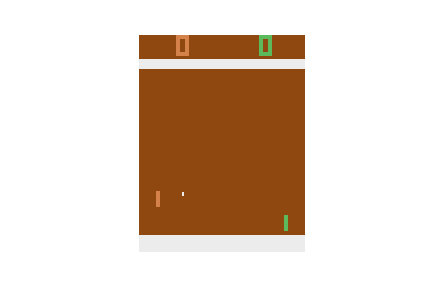
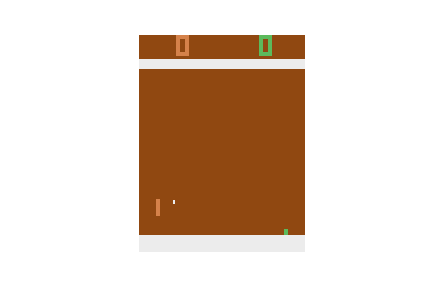
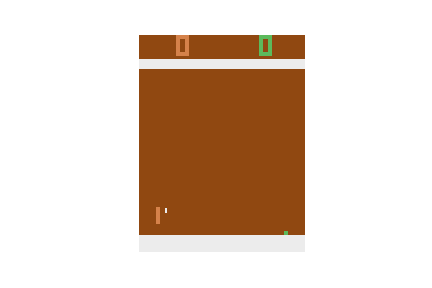
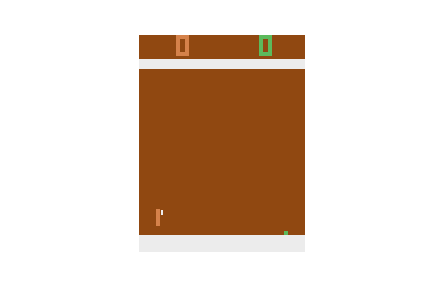
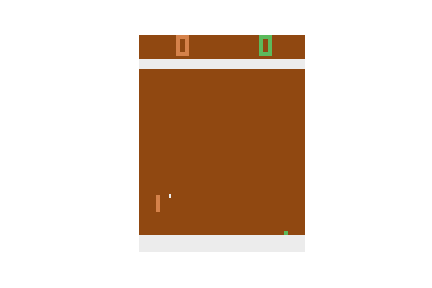
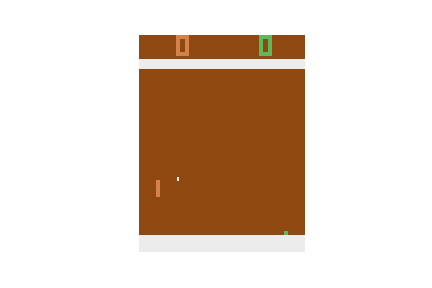
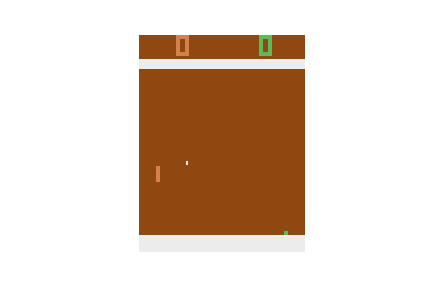
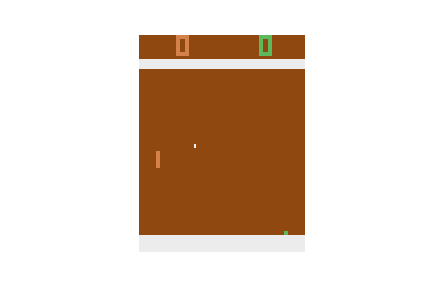
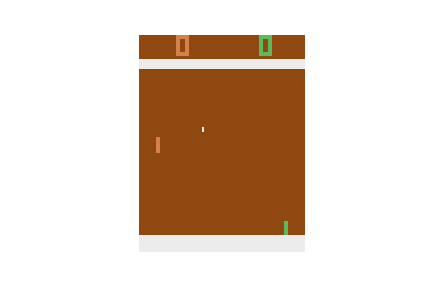
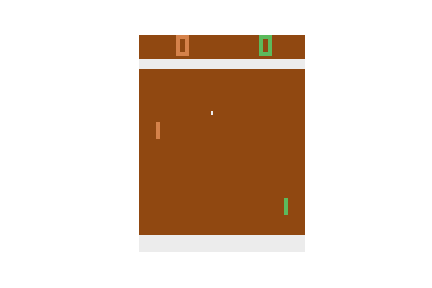
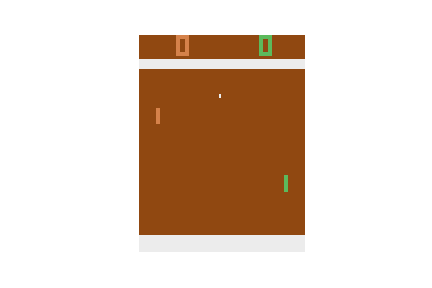
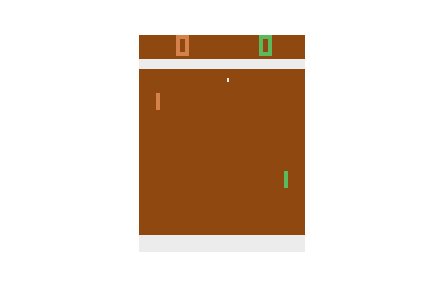
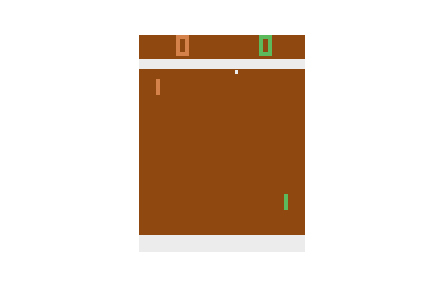
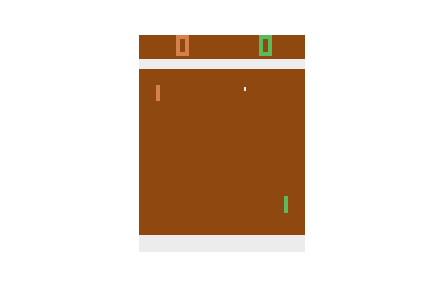
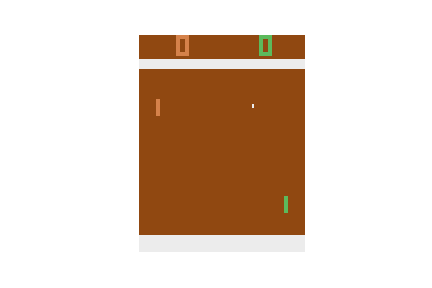
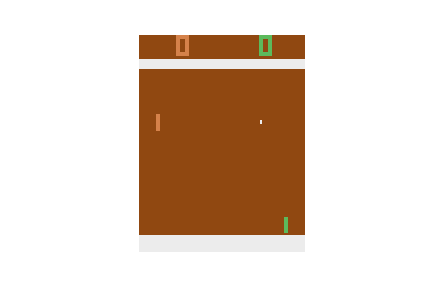
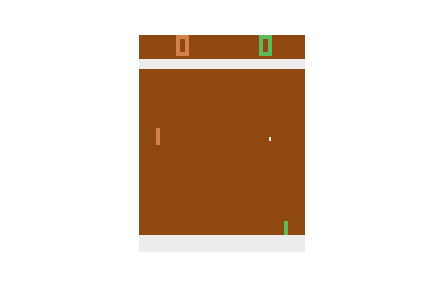
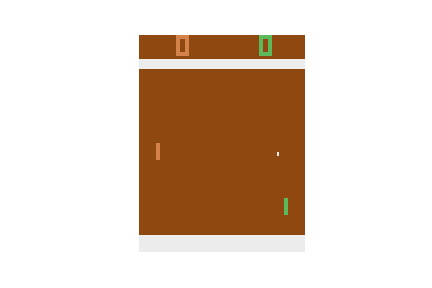
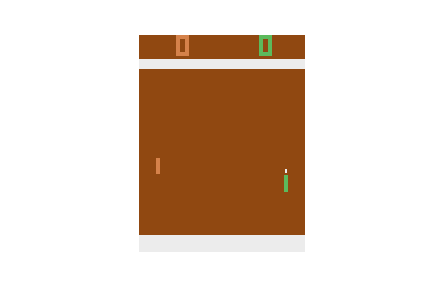
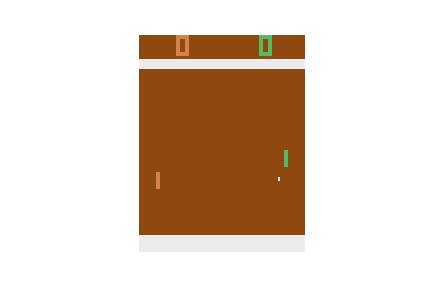
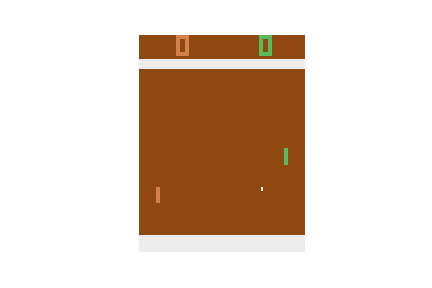
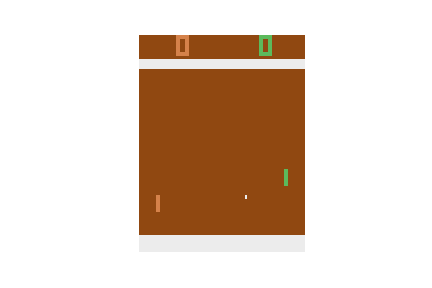
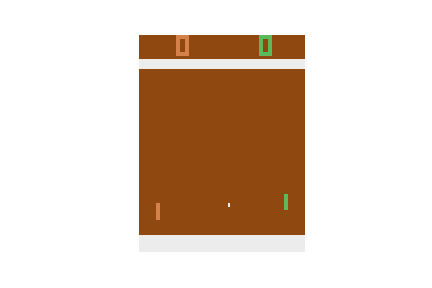
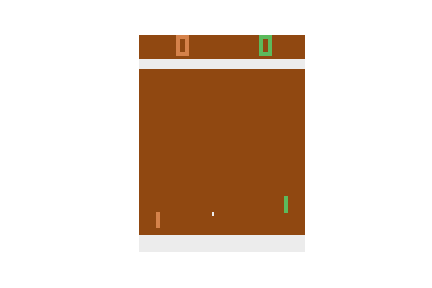
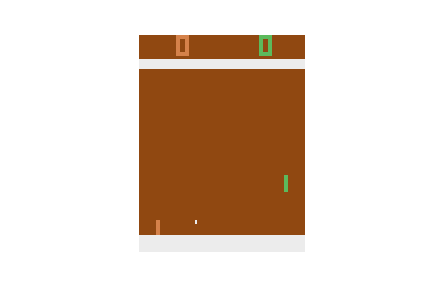
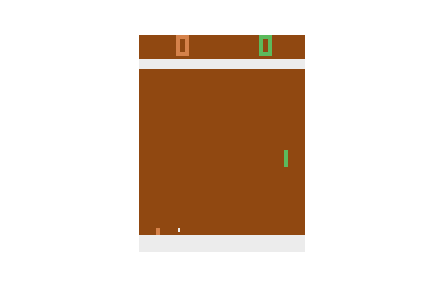
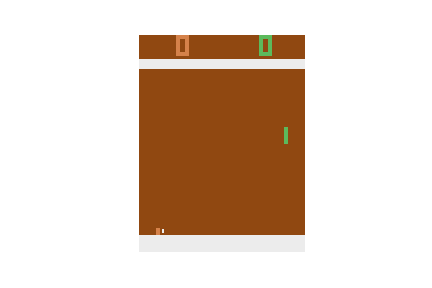
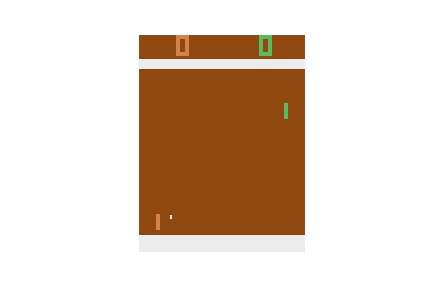
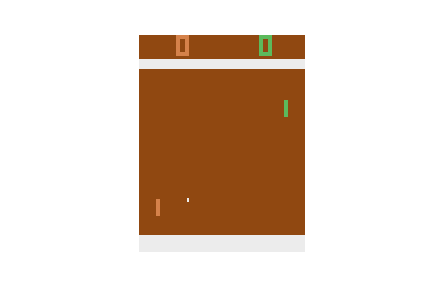
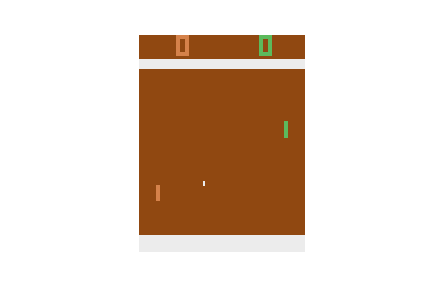
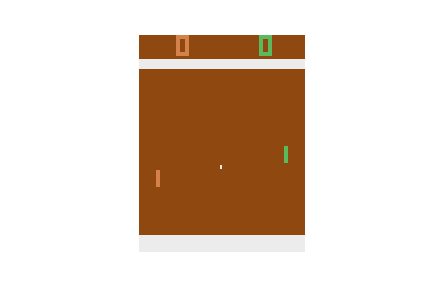
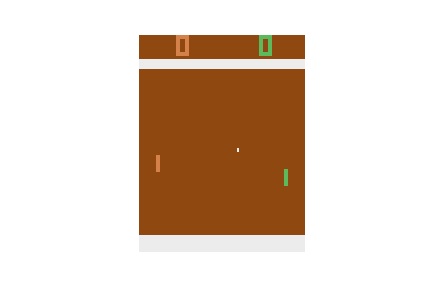
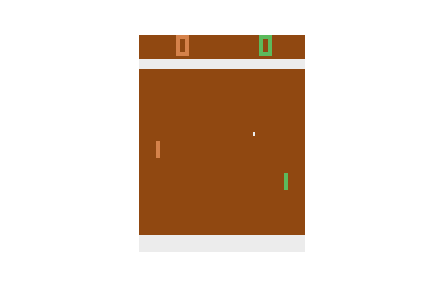
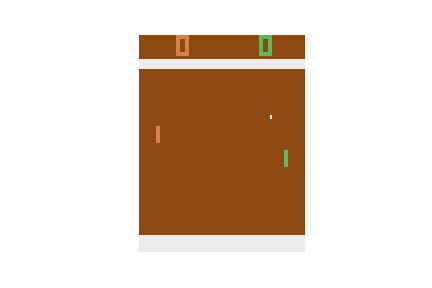
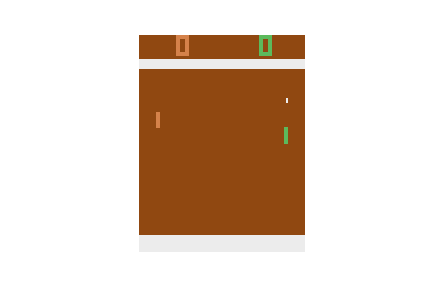
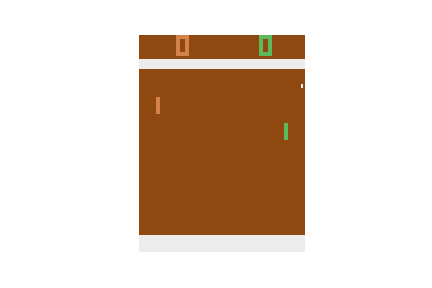
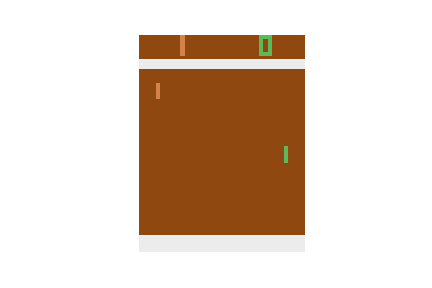
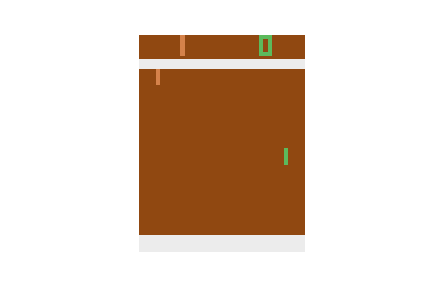
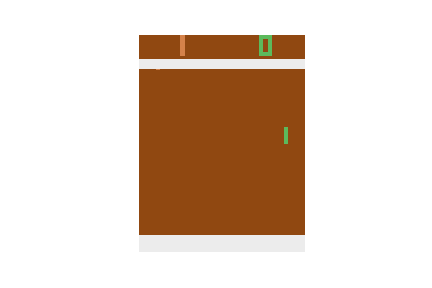
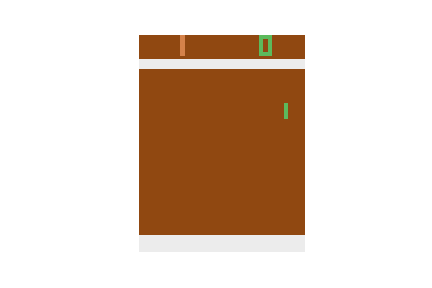
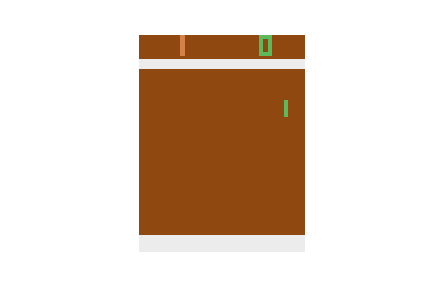
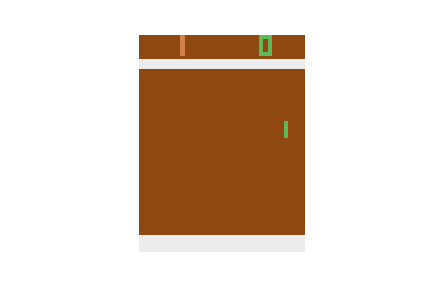
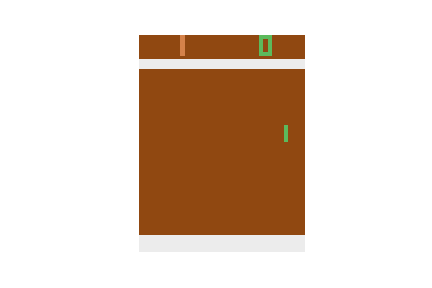
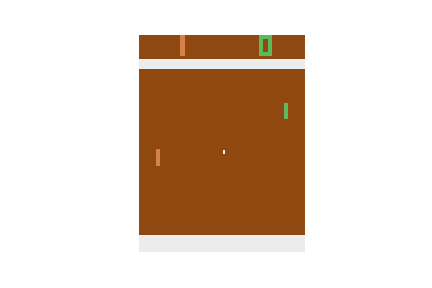
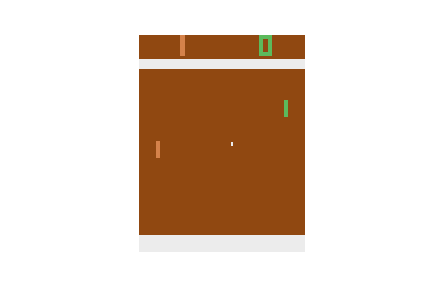
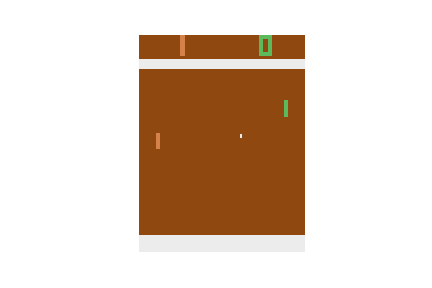
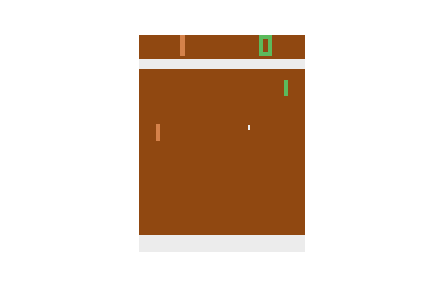
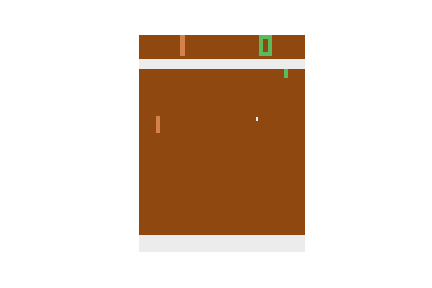
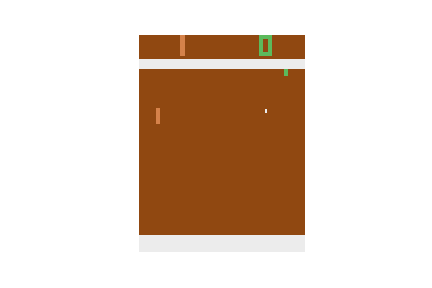
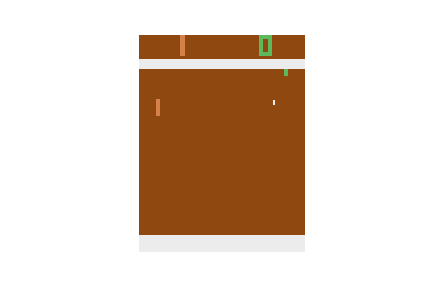
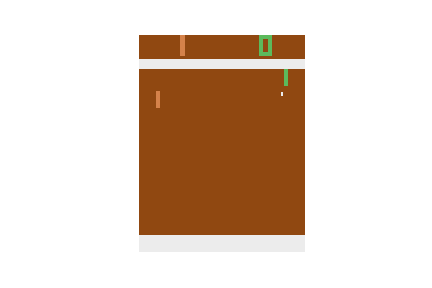
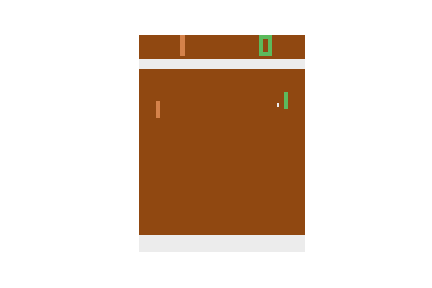
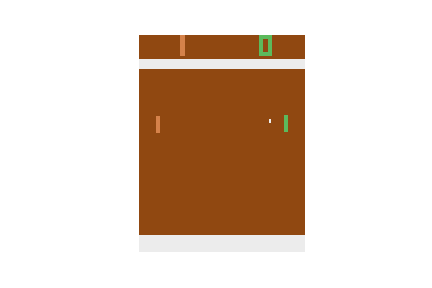
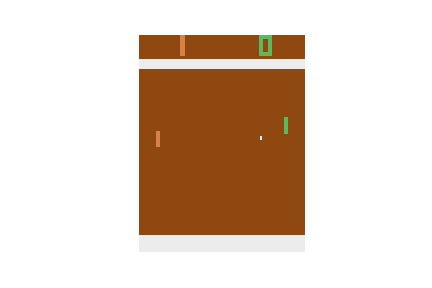
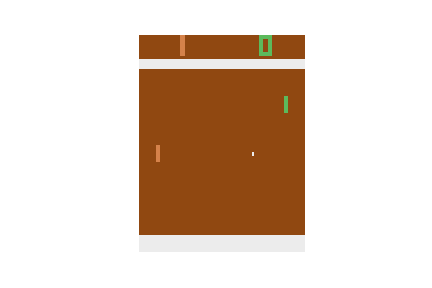
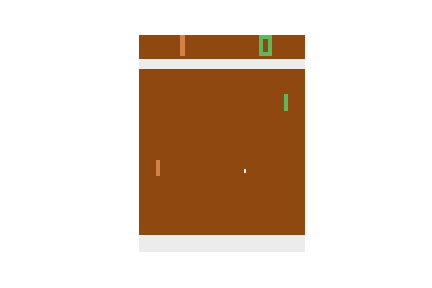
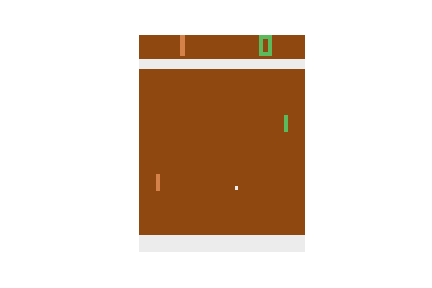
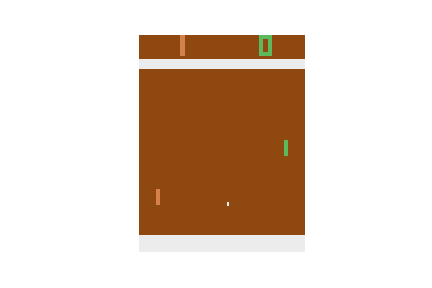
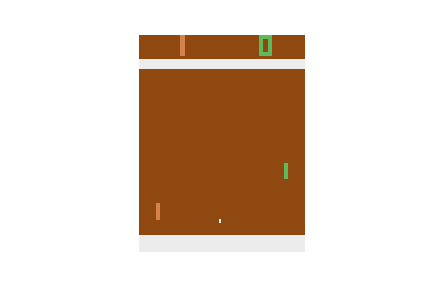
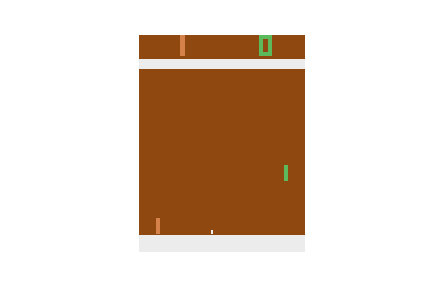
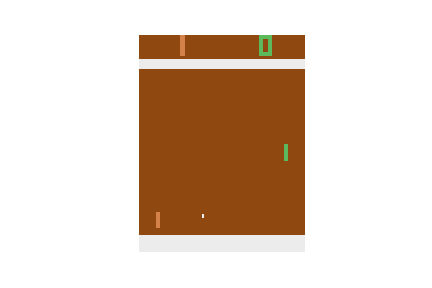
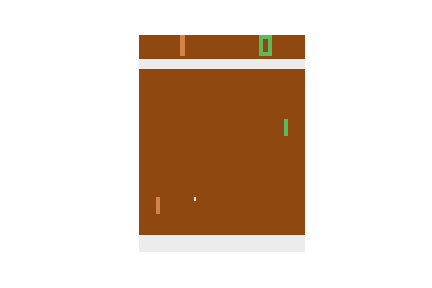
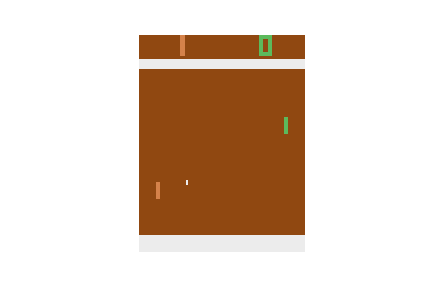
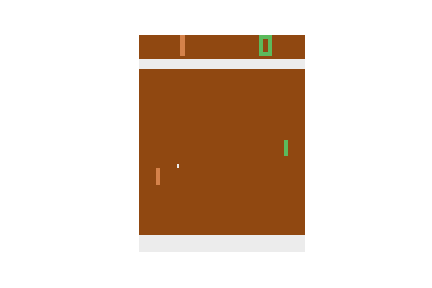
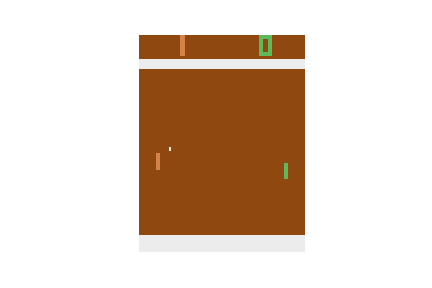
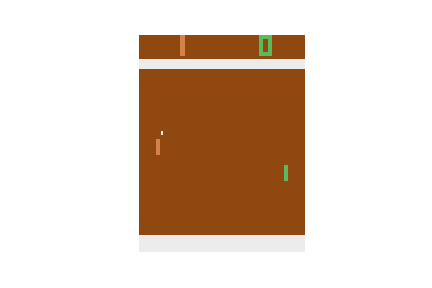
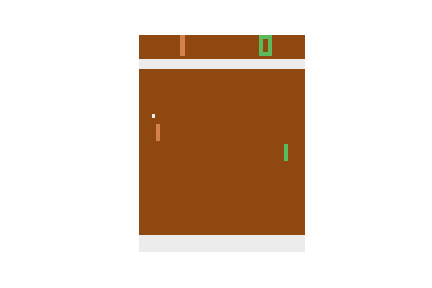
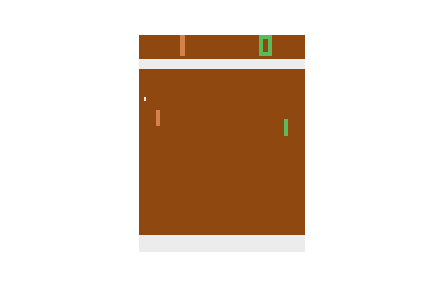
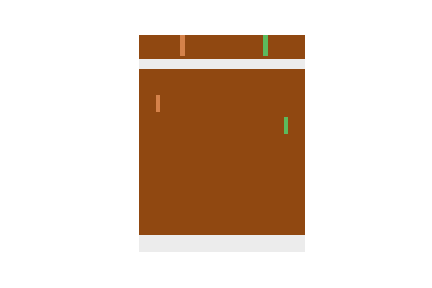
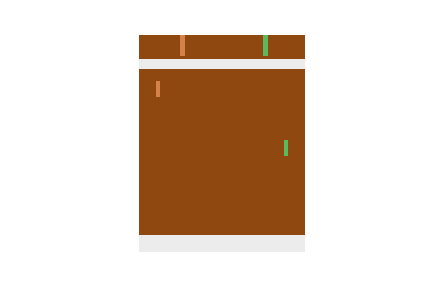
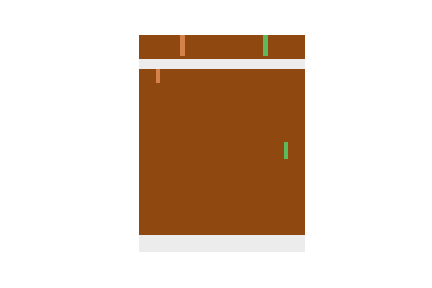
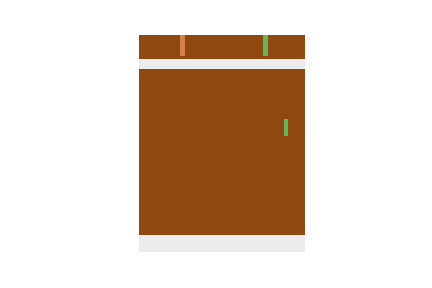
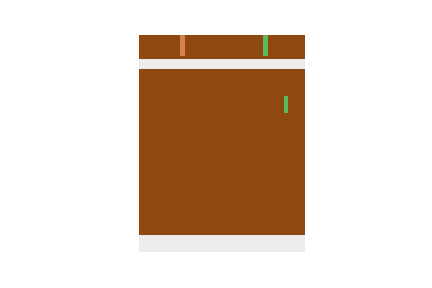
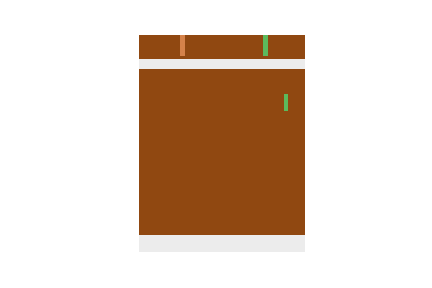
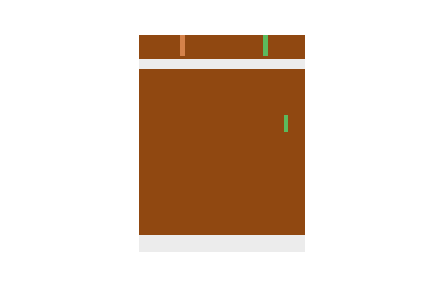
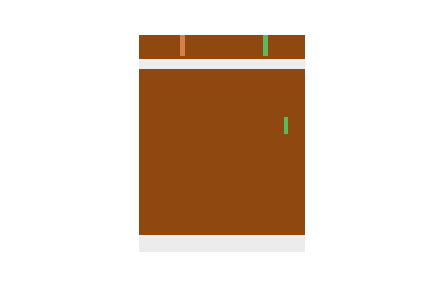
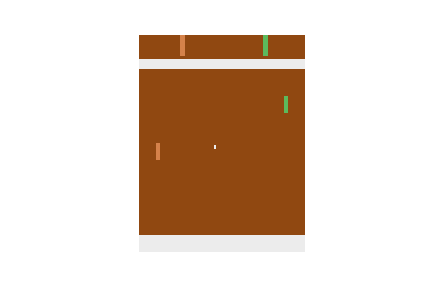
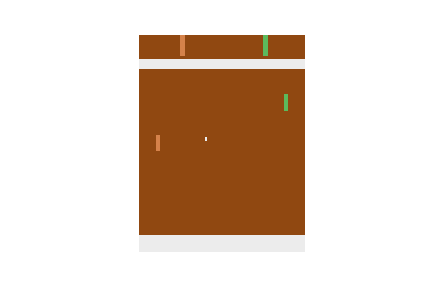
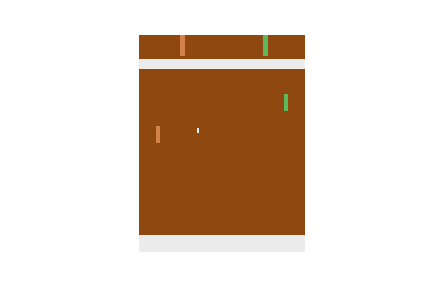
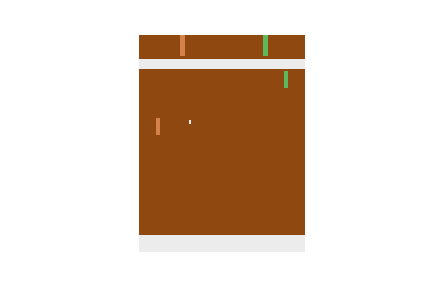
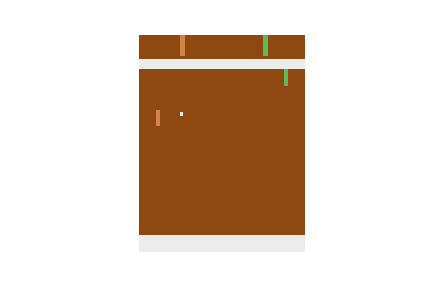
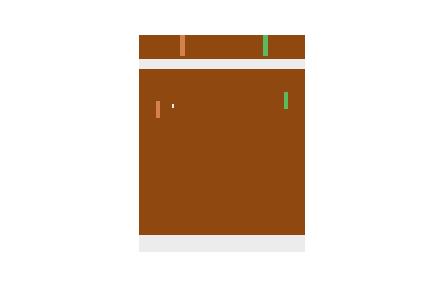
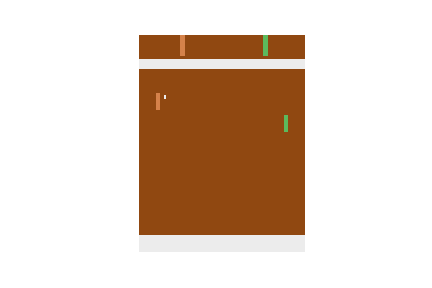
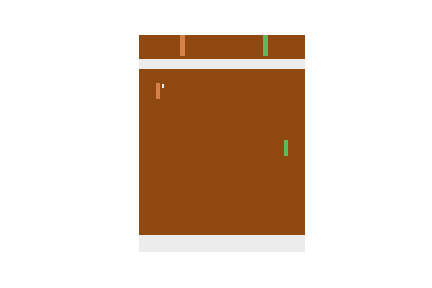
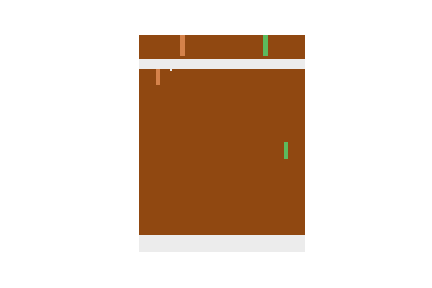
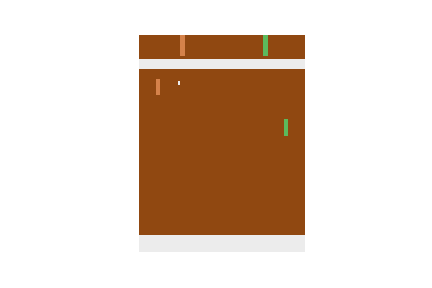
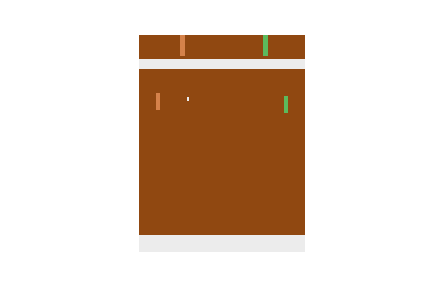
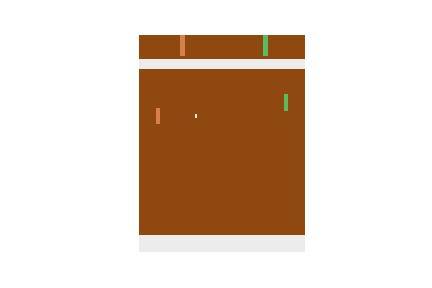
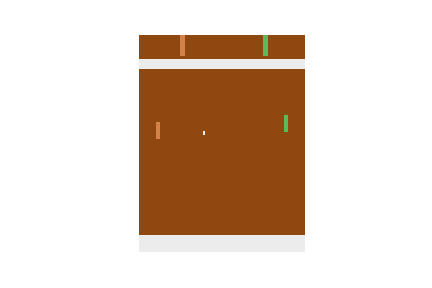
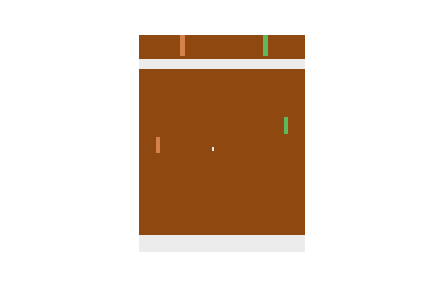
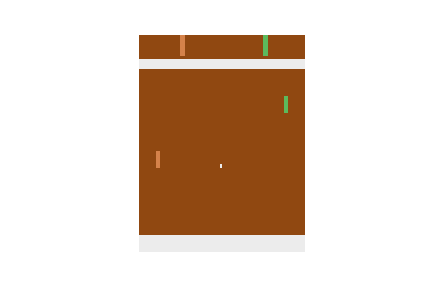
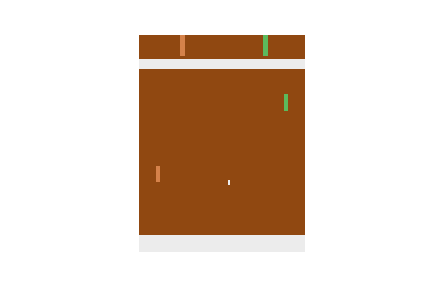
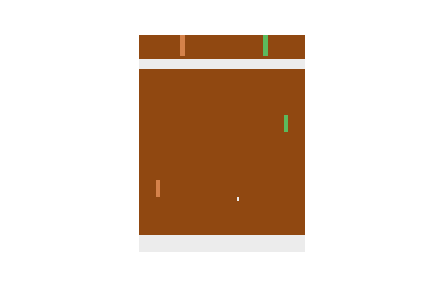
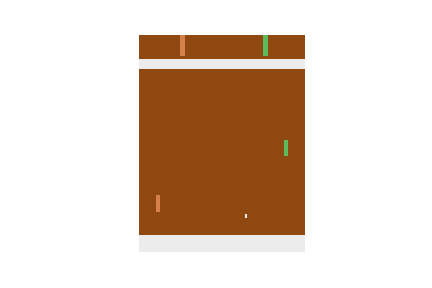
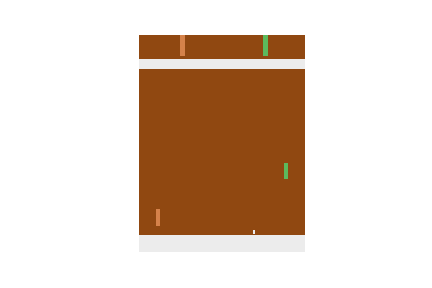
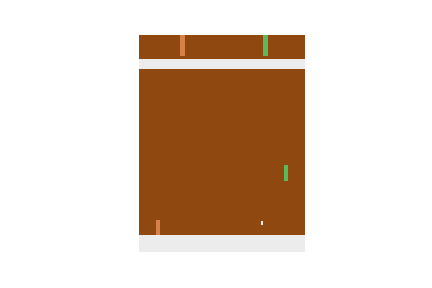
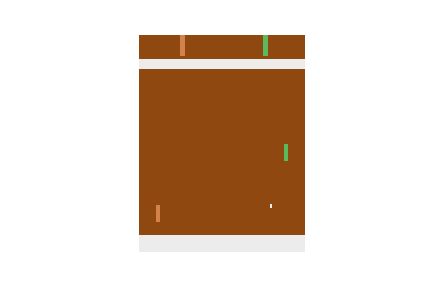
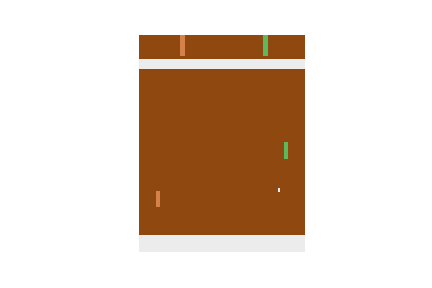
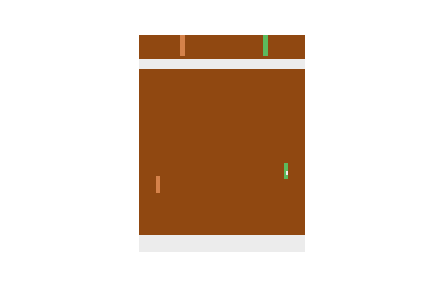
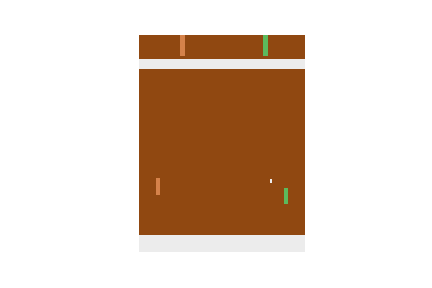
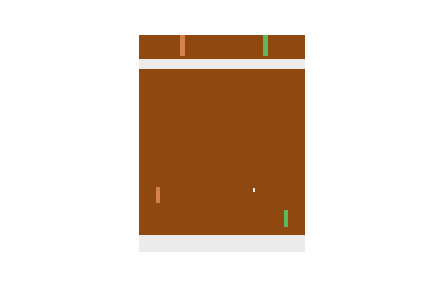
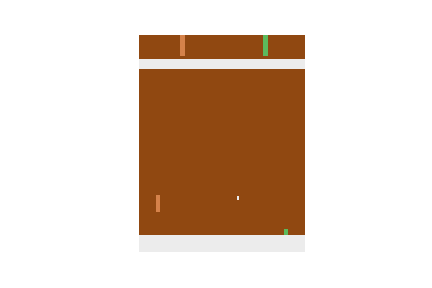
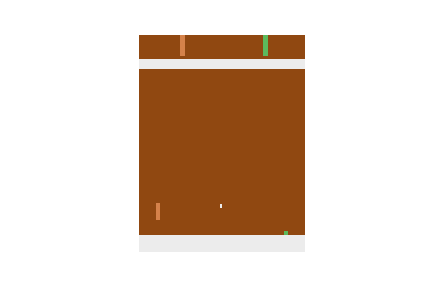
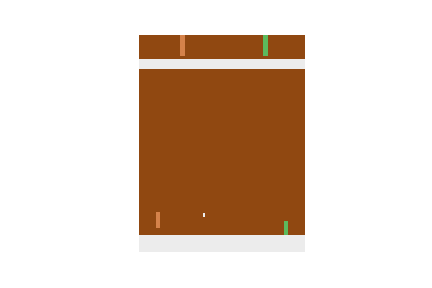
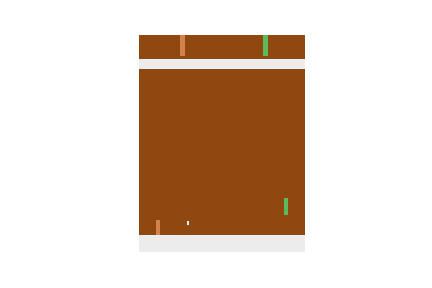
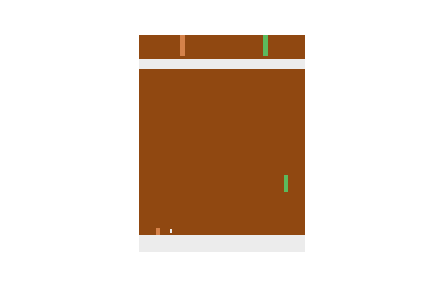
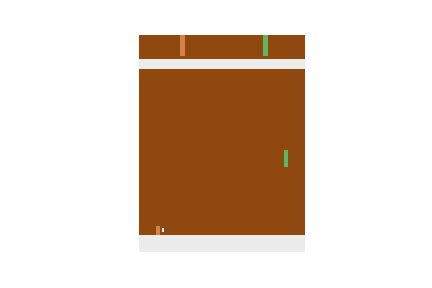
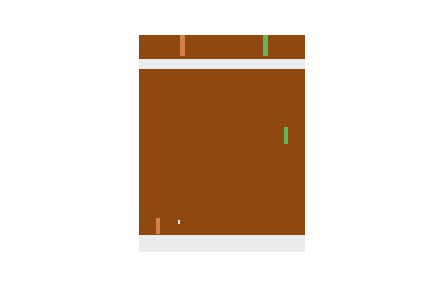
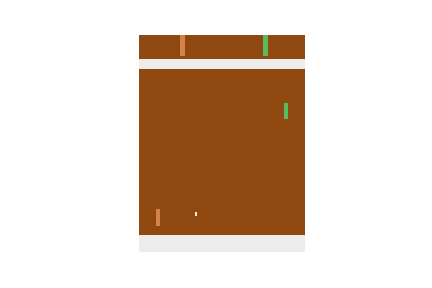
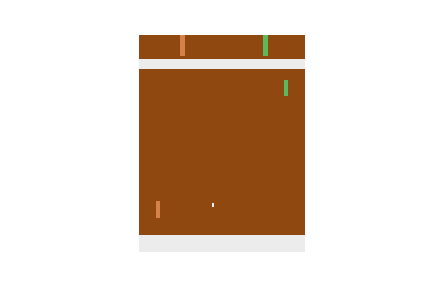
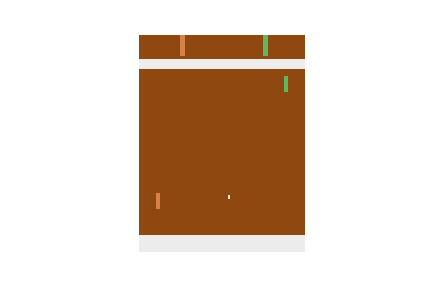
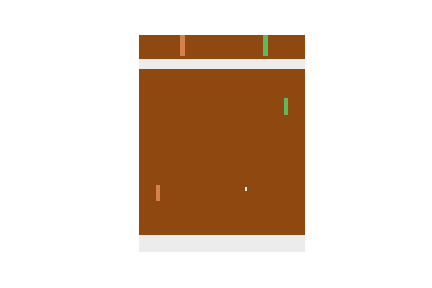
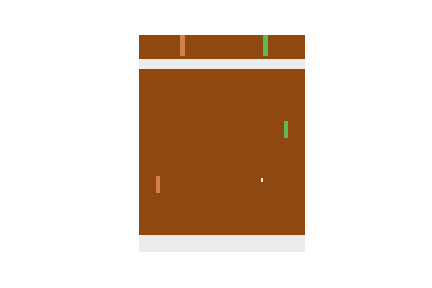
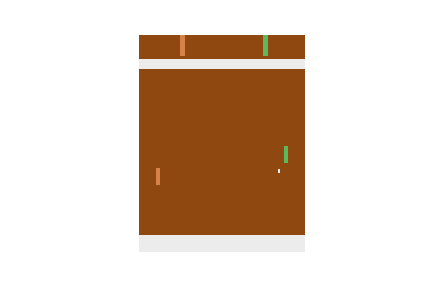
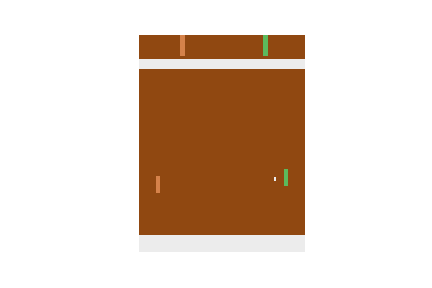
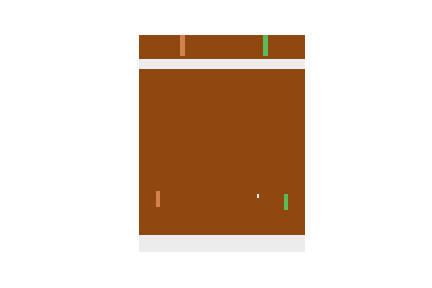
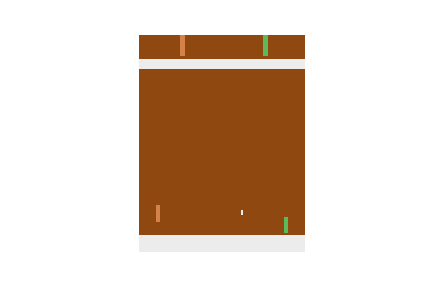
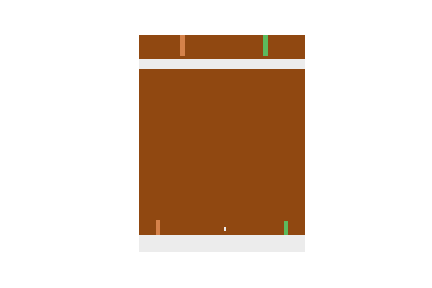
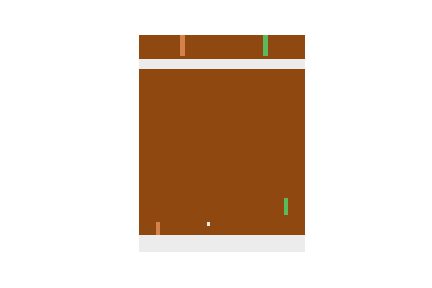
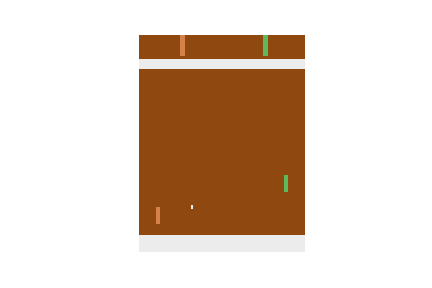
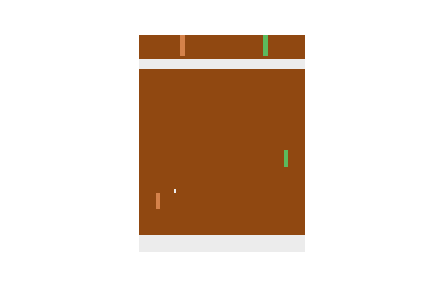
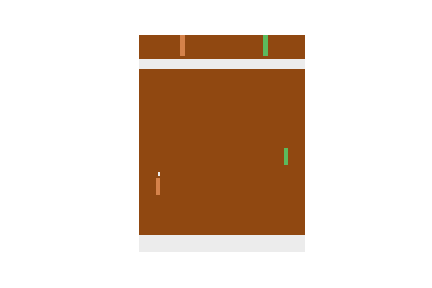
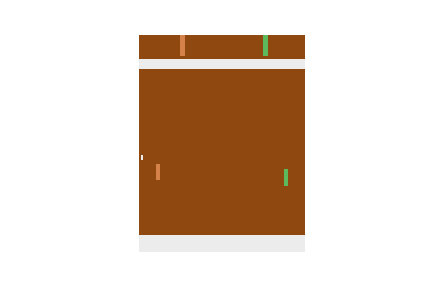
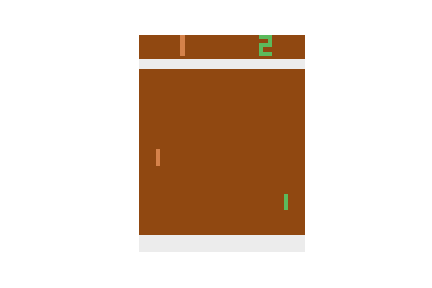
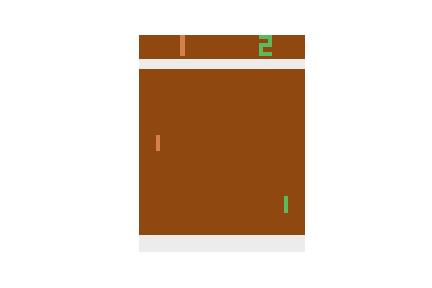
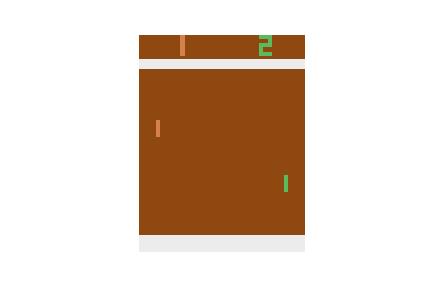
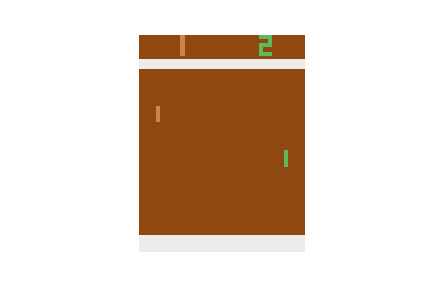
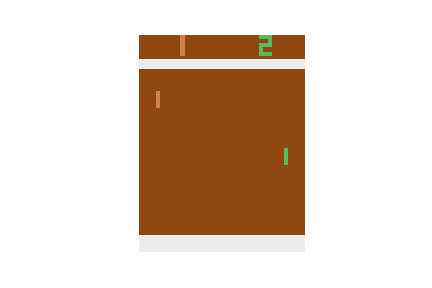
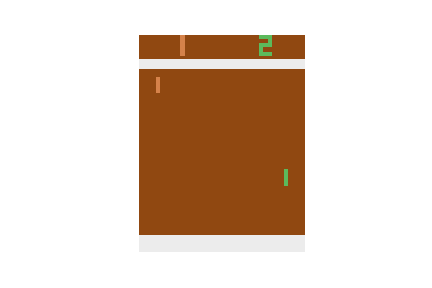
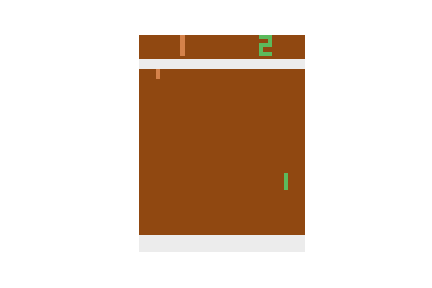
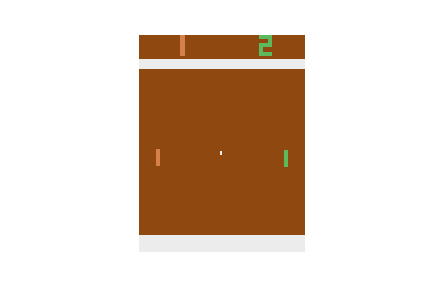
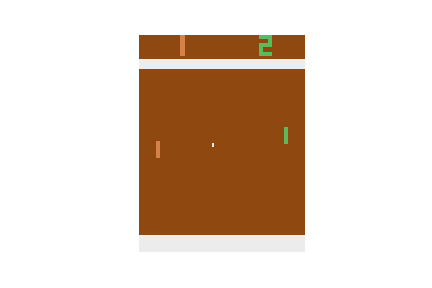
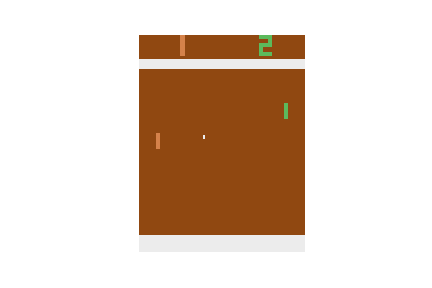
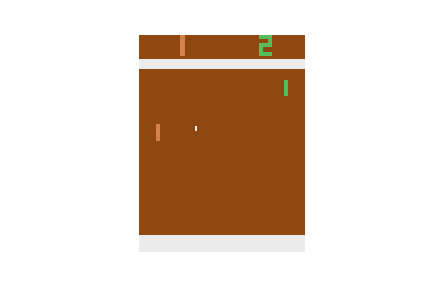
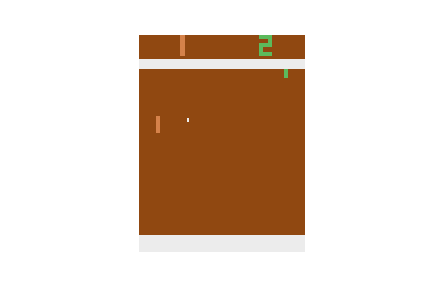
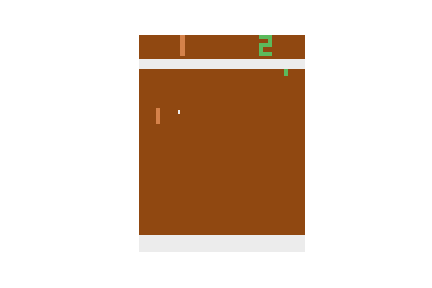
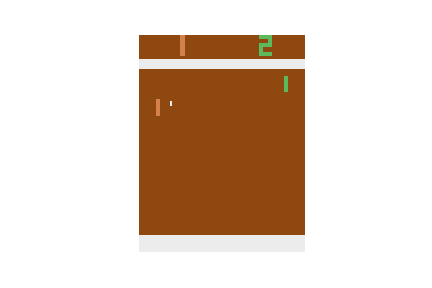
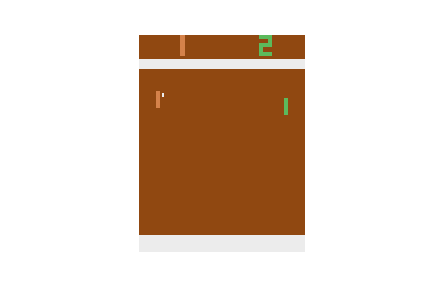
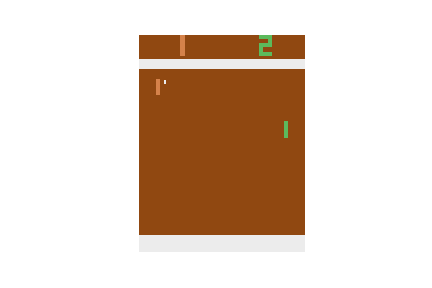
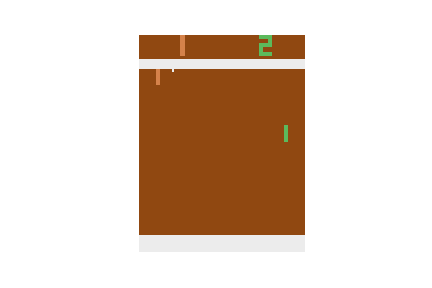
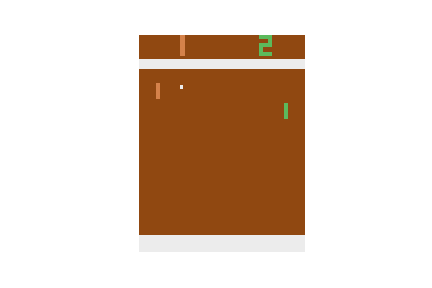
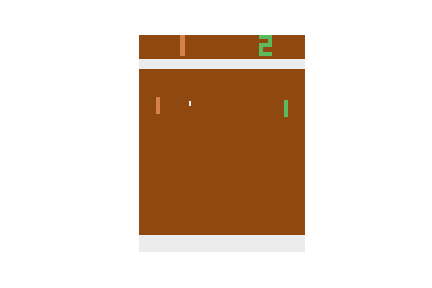
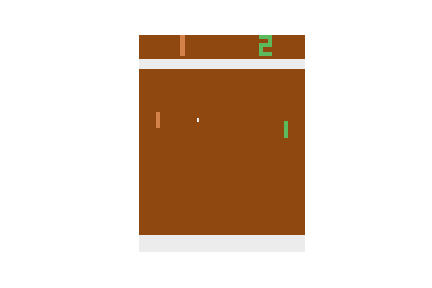
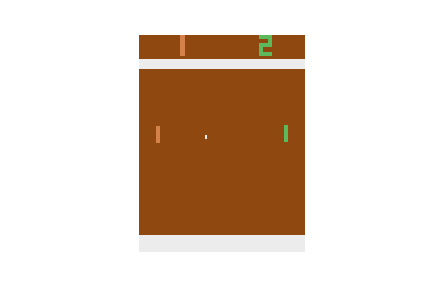
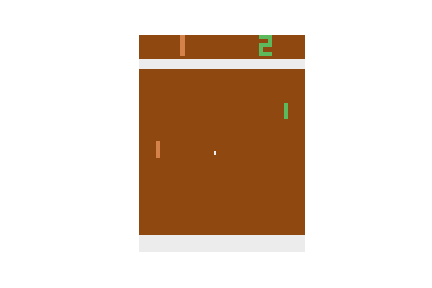
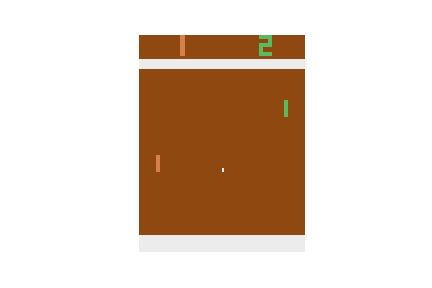
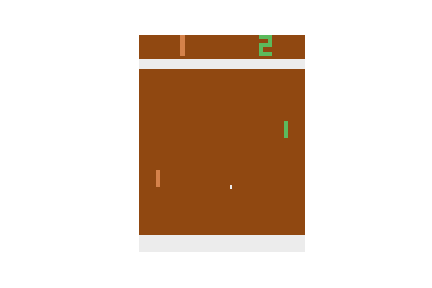
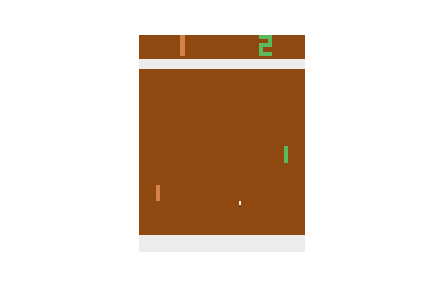
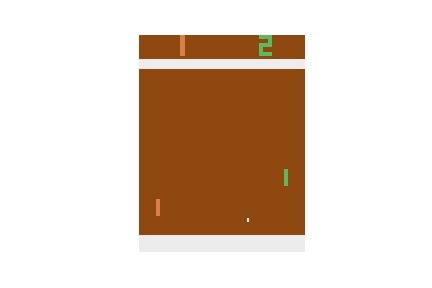
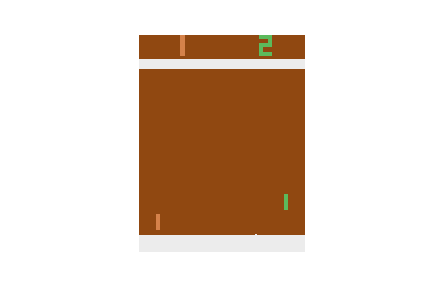
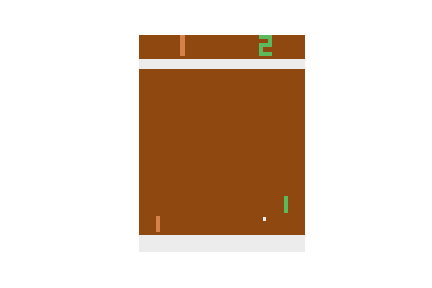
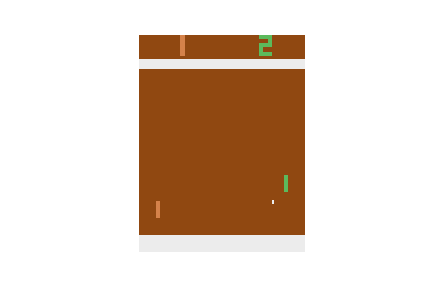
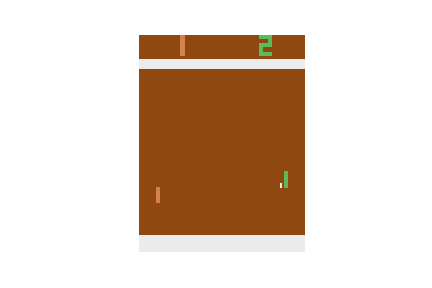
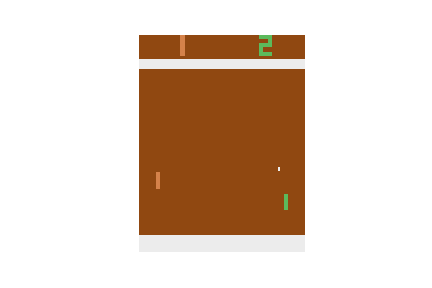
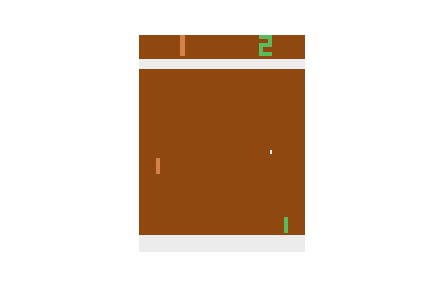
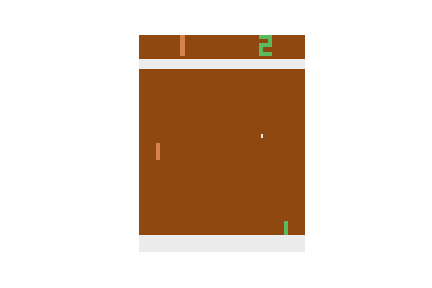
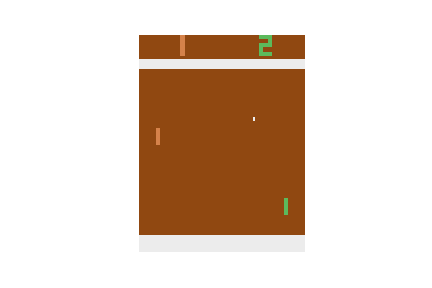
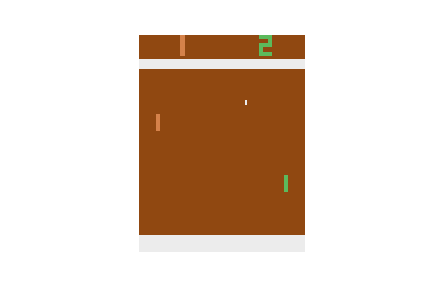
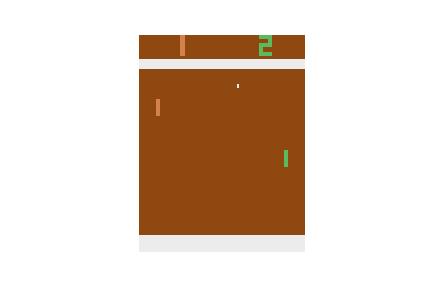
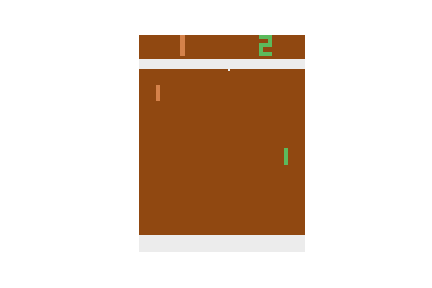
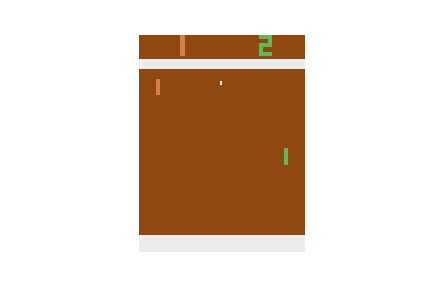
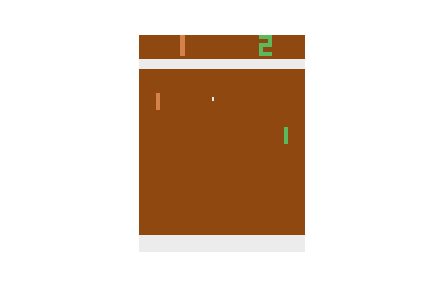
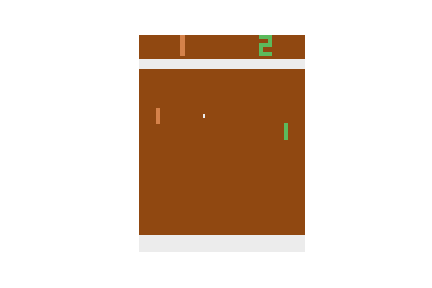
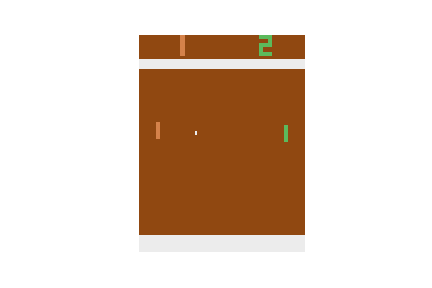
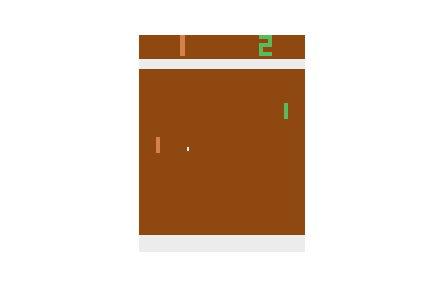
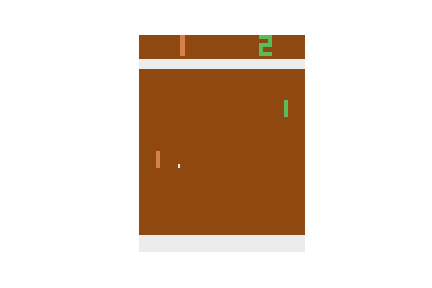
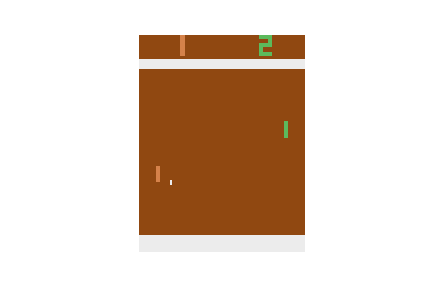
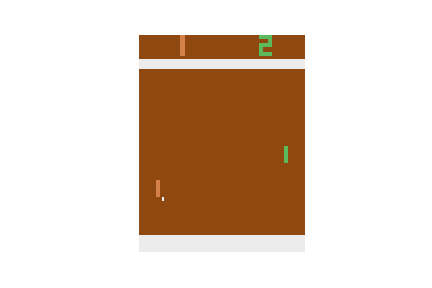
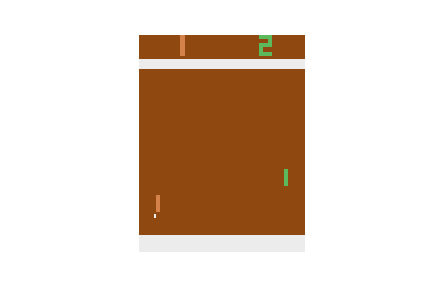
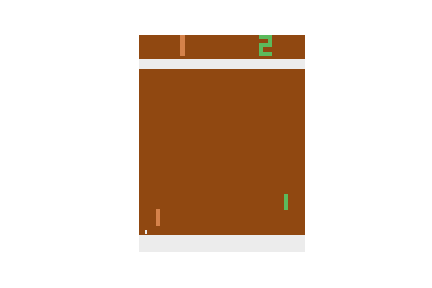
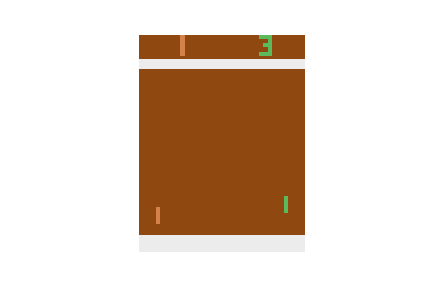
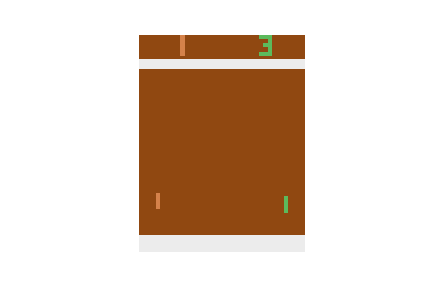
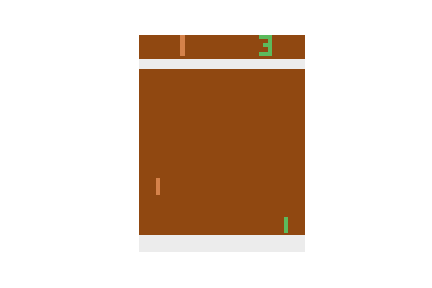
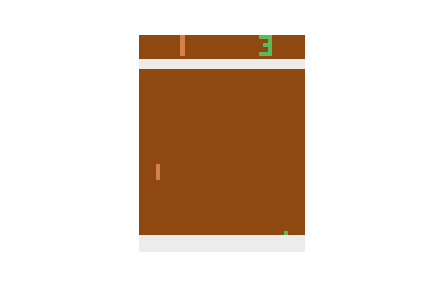
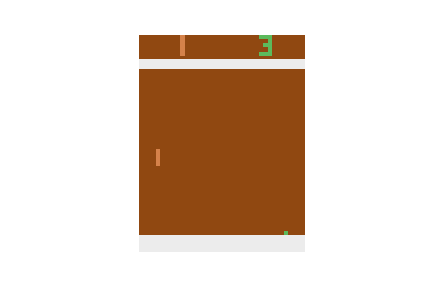
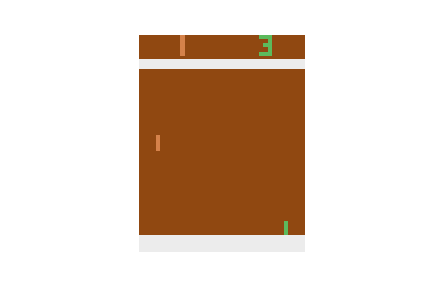
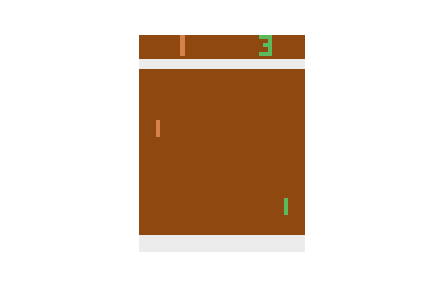
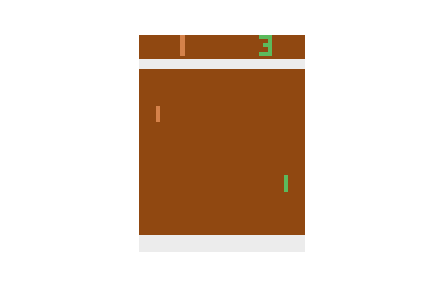
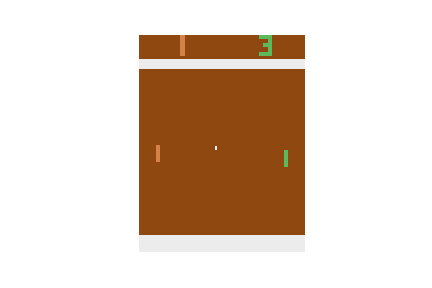
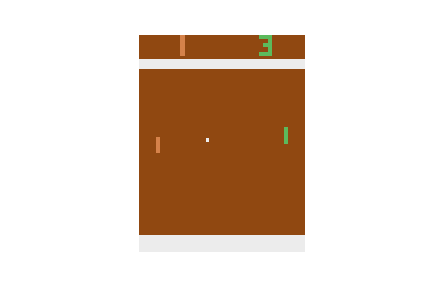
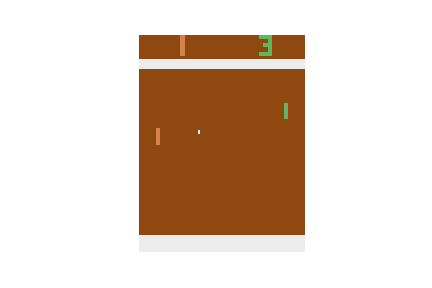
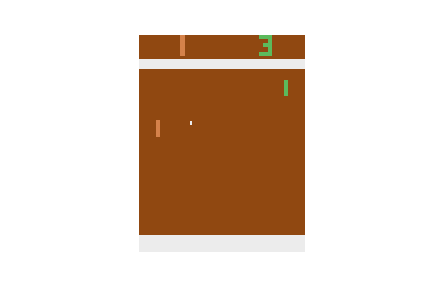
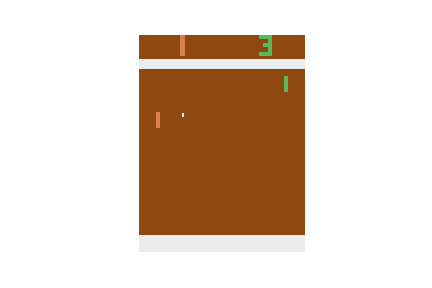
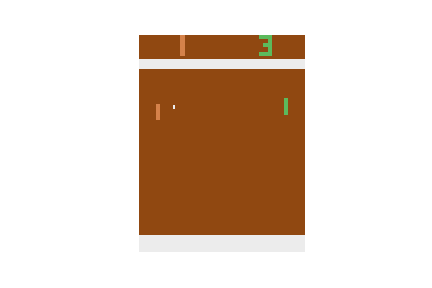
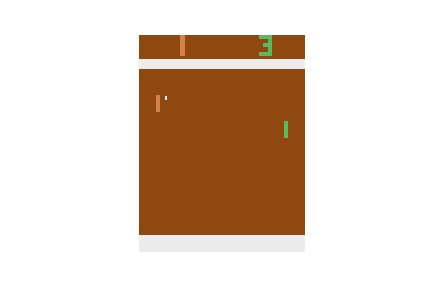
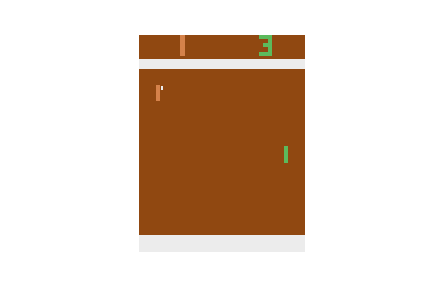
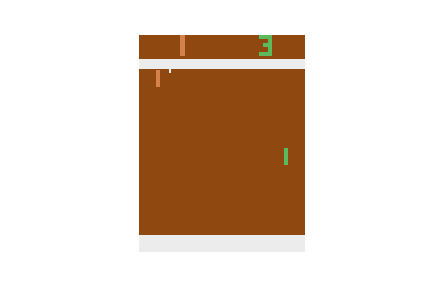
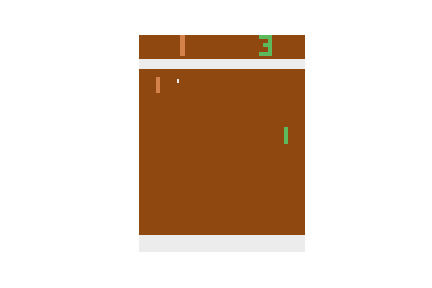
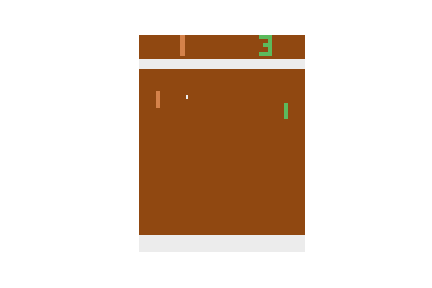
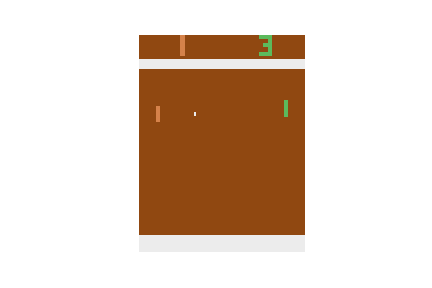
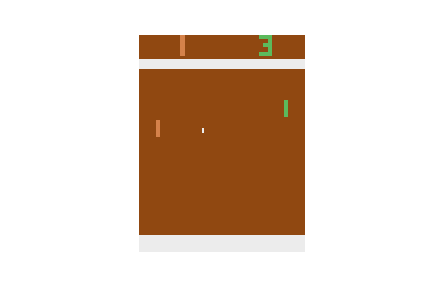
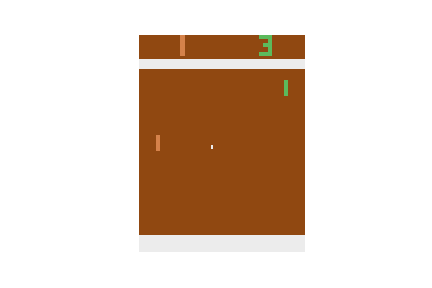
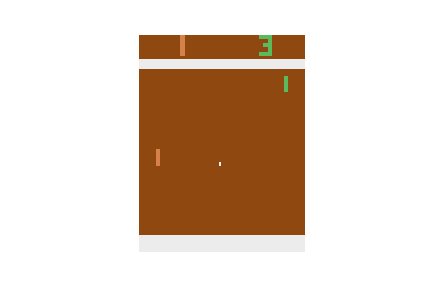
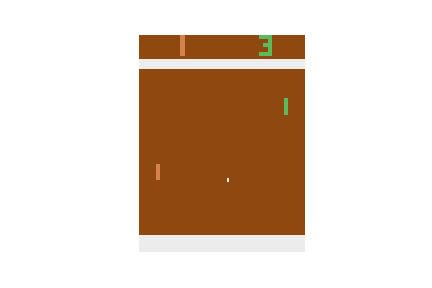

In [9]:
pong_utils.play(env, policy, time=200) 

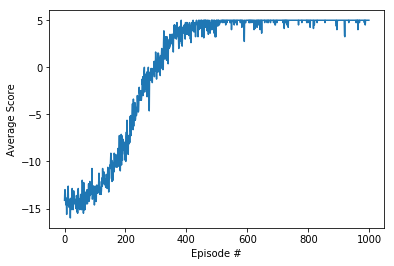

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(mean_rewards)), mean_rewards)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

In [16]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [11]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

!pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [17]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)


In [18]:
import random as rand
def playView(env, policy, time=2000, preprocess=None, nrand=5):
    env = wrap_env(gym.make('PongDeterministic-v4'))
    env.reset()
    # star game
    env.step(1)
    
    # perform nrand random steps in the beginning
    for _ in range(nrand):
        frame1, reward1, is_done, _ = env.step(np.random.choice([RIGHT,LEFT]))
        frame2, reward2, is_done, _ = env.step(0)
    
    
    #Utilize policy to do things
    for _ in range(time):
        #Preprocess input to capture direction and velocity
        frame_input = preprocess_batch([frame1, frame2])
        prob = policy(frame_input)
        
        # RIGHT = 4, LEFT = 5
        action = RIGHT if rand.random() < prob else LEFT
        frame1, _, is_done, _ = env.step(action)
        frame2, _, is_done, _ = env.step(0)

        

        if is_done:
            break
    
    env.close()
    
    show_video()
    return 

playView(env, policy, time=500)